# Forecast the Airlines Passengers.
### Prepare a document for each model explaining how many dummy variables you have created and RMSE value for each model. Finally which model you will use for Forecasting.

## What is Forecasting a Time series ?

- Time series forecasting means to forecast or to predict the future value over a period of time. It entails developing models based on previous data and applying them to make observations and guide future strategic decisions.
- Time series forecasting is one of the most applied data science technique in business,finance,production and inventory planning,Supply chanin management.
- Many prediction problems involve the time component amd thus require extrapolation of thims series data or time series forecasting .
- Time sereis forecasting is also an imp area of Machine Lerning and b=can be act as a Supervised Learning Problem.
- ML methods such as Regression.Neural Network , XGBoost, Support vector Machines - can be applied to it.
- Forecasting involves taking models fit on historical data and using them to predict future observations.

- **Time series forecasting is a technique for the prediction of events through a sequence of time. It predicts future events by analyzing the trends of the past, on the assumption that future trends will hold similar to historical trends. It is used across many fields of study in various applications including:**
- Astronomy
- Business planning
- Control engineering
- Earthquake prediction
- Econometrics
- Mathematical finance
- Pattern recognition
- Resources allocation
- Signal processing
- Statistics
- Weather forecasting


In [216]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px


from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.holtwinters import SimpleExpSmoothing,ExponentialSmoothing,Holt,HoltWintersResults

import warnings
warnings.filterwarnings('ignore')


In [217]:
air=pd.read_excel('Airlines+Data.xlsx')
air

Month  Passengers
0  1995-01-01         112
1  1995-02-01         118
2  1995-03-01         132
3  1995-04-01         129
4  1995-05-01         121
..        ...         ...
91 2002-08-01         405
92 2002-09-01         355
93 2002-10-01         306
94 2002-11-01         271
95 2002-12-01         306

[96 rows x 2 columns]

In [218]:
air.rename({'Month':'Date'},axis=1,inplace=True)

In [219]:
air.head()

Date  Passengers
0 1995-01-01         112
1 1995-02-01         118
2 1995-03-01         132
3 1995-04-01         129
4 1995-05-01         121

## Data Exploration

<AxesSubplot: >

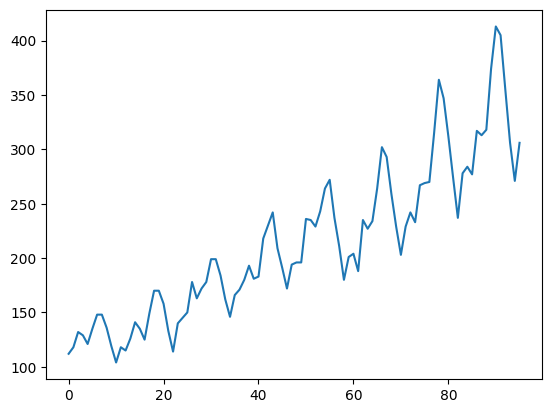

In [220]:
air.Passengers.plot()

In [221]:
air.isnull().sum()

Date          0
Passengers    0
dtype: int64

In [222]:
air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


- We have no missing data so all the entries are valid for use.
- datetime is dtype of Month and int64 is dtype of Passengere  



In [223]:
air.value_counts()

Date        Passengers
1995-01-01  112           1
1995-02-01  118           1
2000-11-01  203           1
2000-10-01  229           1
2000-09-01  259           1
                         ..
1997-06-01  178           1
1997-05-01  172           1
1997-04-01  163           1
1997-03-01  178           1
2002-12-01  306           1
Length: 96, dtype: int64

In [224]:
air.nunique()

Date          96
Passengers    80
dtype: int64

In [225]:
air.describe()

Passengers
count   96.000000
mean   213.708333
std     71.918216
min    104.000000
25%    156.000000
50%    200.000000
75%    264.750000
max    413.000000

## Feature Engineering


#### Separating Month and Year into Separate Column for Visualization and removing meaningful insight of the data.

In [242]:
df=air.copy()
df['Date']=pd.to_datetime(df.Date,format='%b-%y')
# month extraction
df['Month']=df.Date.dt.strftime('%b')
# year extraction
df['Year']=df.Date.dt.strftime('%Y')
df.head()

Date  Passengers Month  Year
0 1995-01-01         112   Jan  1995
1 1995-02-01         118   Feb  1995
2 1995-03-01         132   Mar  1995
3 1995-04-01         129   Apr  1995
4 1995-05-01         121   May  1995

In [227]:
df.set_index('Date',inplace=True)
df.index.year

Int64Index([1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995,
            1995, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996,
            1996, 1996, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997,
            1997, 1997, 1997, 1998, 1998, 1998, 1998, 1998, 1998, 1998, 1998,
            1998, 1998, 1998, 1998, 1999, 1999, 1999, 1999, 1999, 1999, 1999,
            1999, 1999, 1999, 1999, 1999, 2000, 2000, 2000, 2000, 2000, 2000,
            2000, 2000, 2000, 2000, 2000, 2000, 2001, 2001, 2001, 2001, 2001,
            2001, 2001, 2001, 2001, 2001, 2001, 2001, 2002, 2002, 2002, 2002,
            2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002],
           dtype='int64', name='Date')

# Data Visualisation

<AxesSubplot: xlabel='Month', ylabel='Year'>

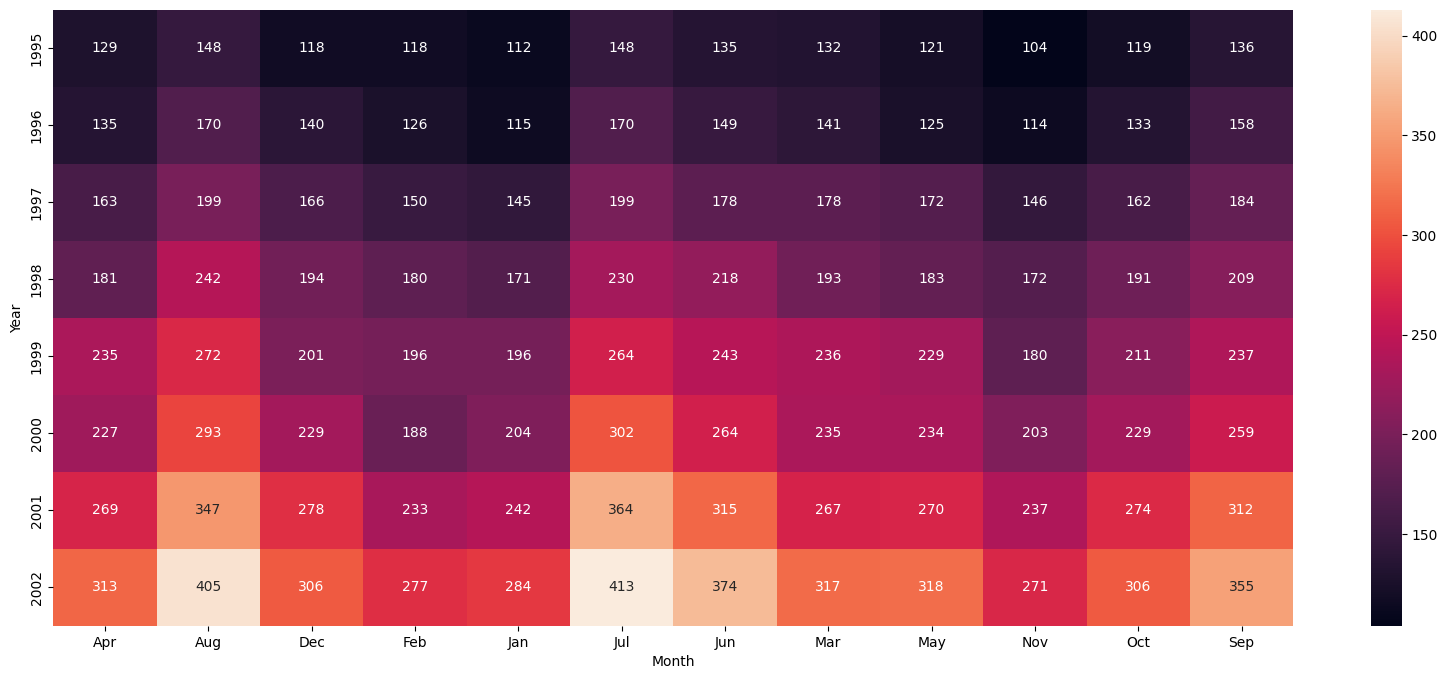

In [228]:
plt.figure(figsize=(20,8))
heatmap_y_m=pd.pivot_table(data=df,values='Passengers',index='Year',columns="Month",aggfunc="mean",fill_value=0)
sn.heatmap(heatmap_y_m,annot=True,fmt='g')

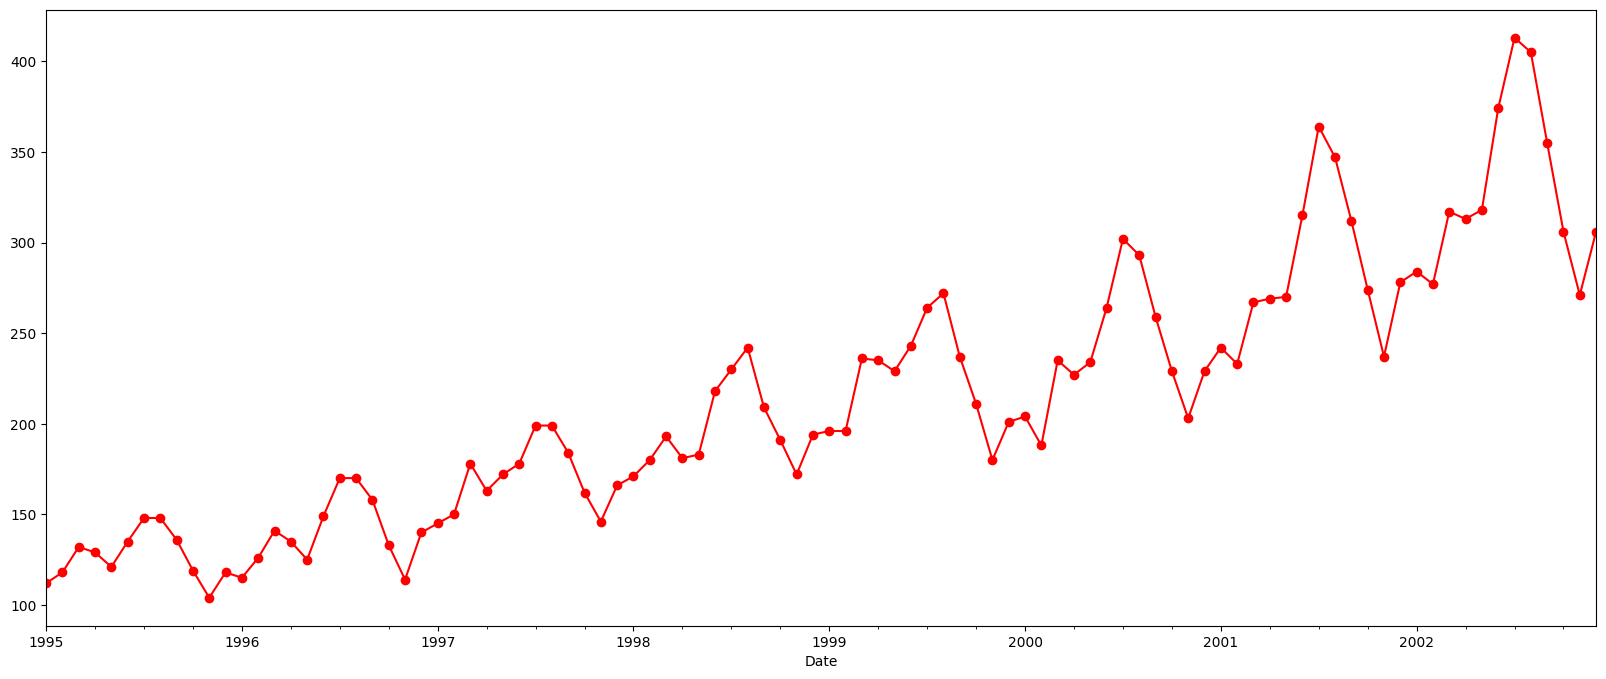

In [229]:
# Line plot
df['Passengers'].plot(figsize=(20, 8),color='red',marker='o')
plt.show()

- We can see that there is an increasing Trend. So, Trend is not constant.
- Variance is also not constant.

Hence the time series is not stationary.

### Yearly Passenger Analysis

<AxesSubplot: xlabel='Year', ylabel='Passengers'>

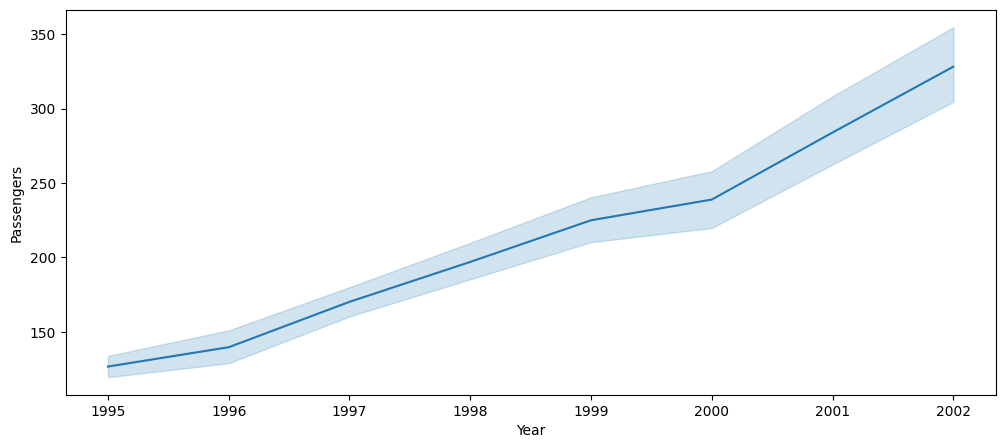

In [230]:
plt.figure(figsize=(12,5))

sn.lineplot(x='Year',y='Passengers',data=df)


### Box plot for each year by monthly intervals

<AxesSubplot: xlabel='Year', ylabel='Passengers'>

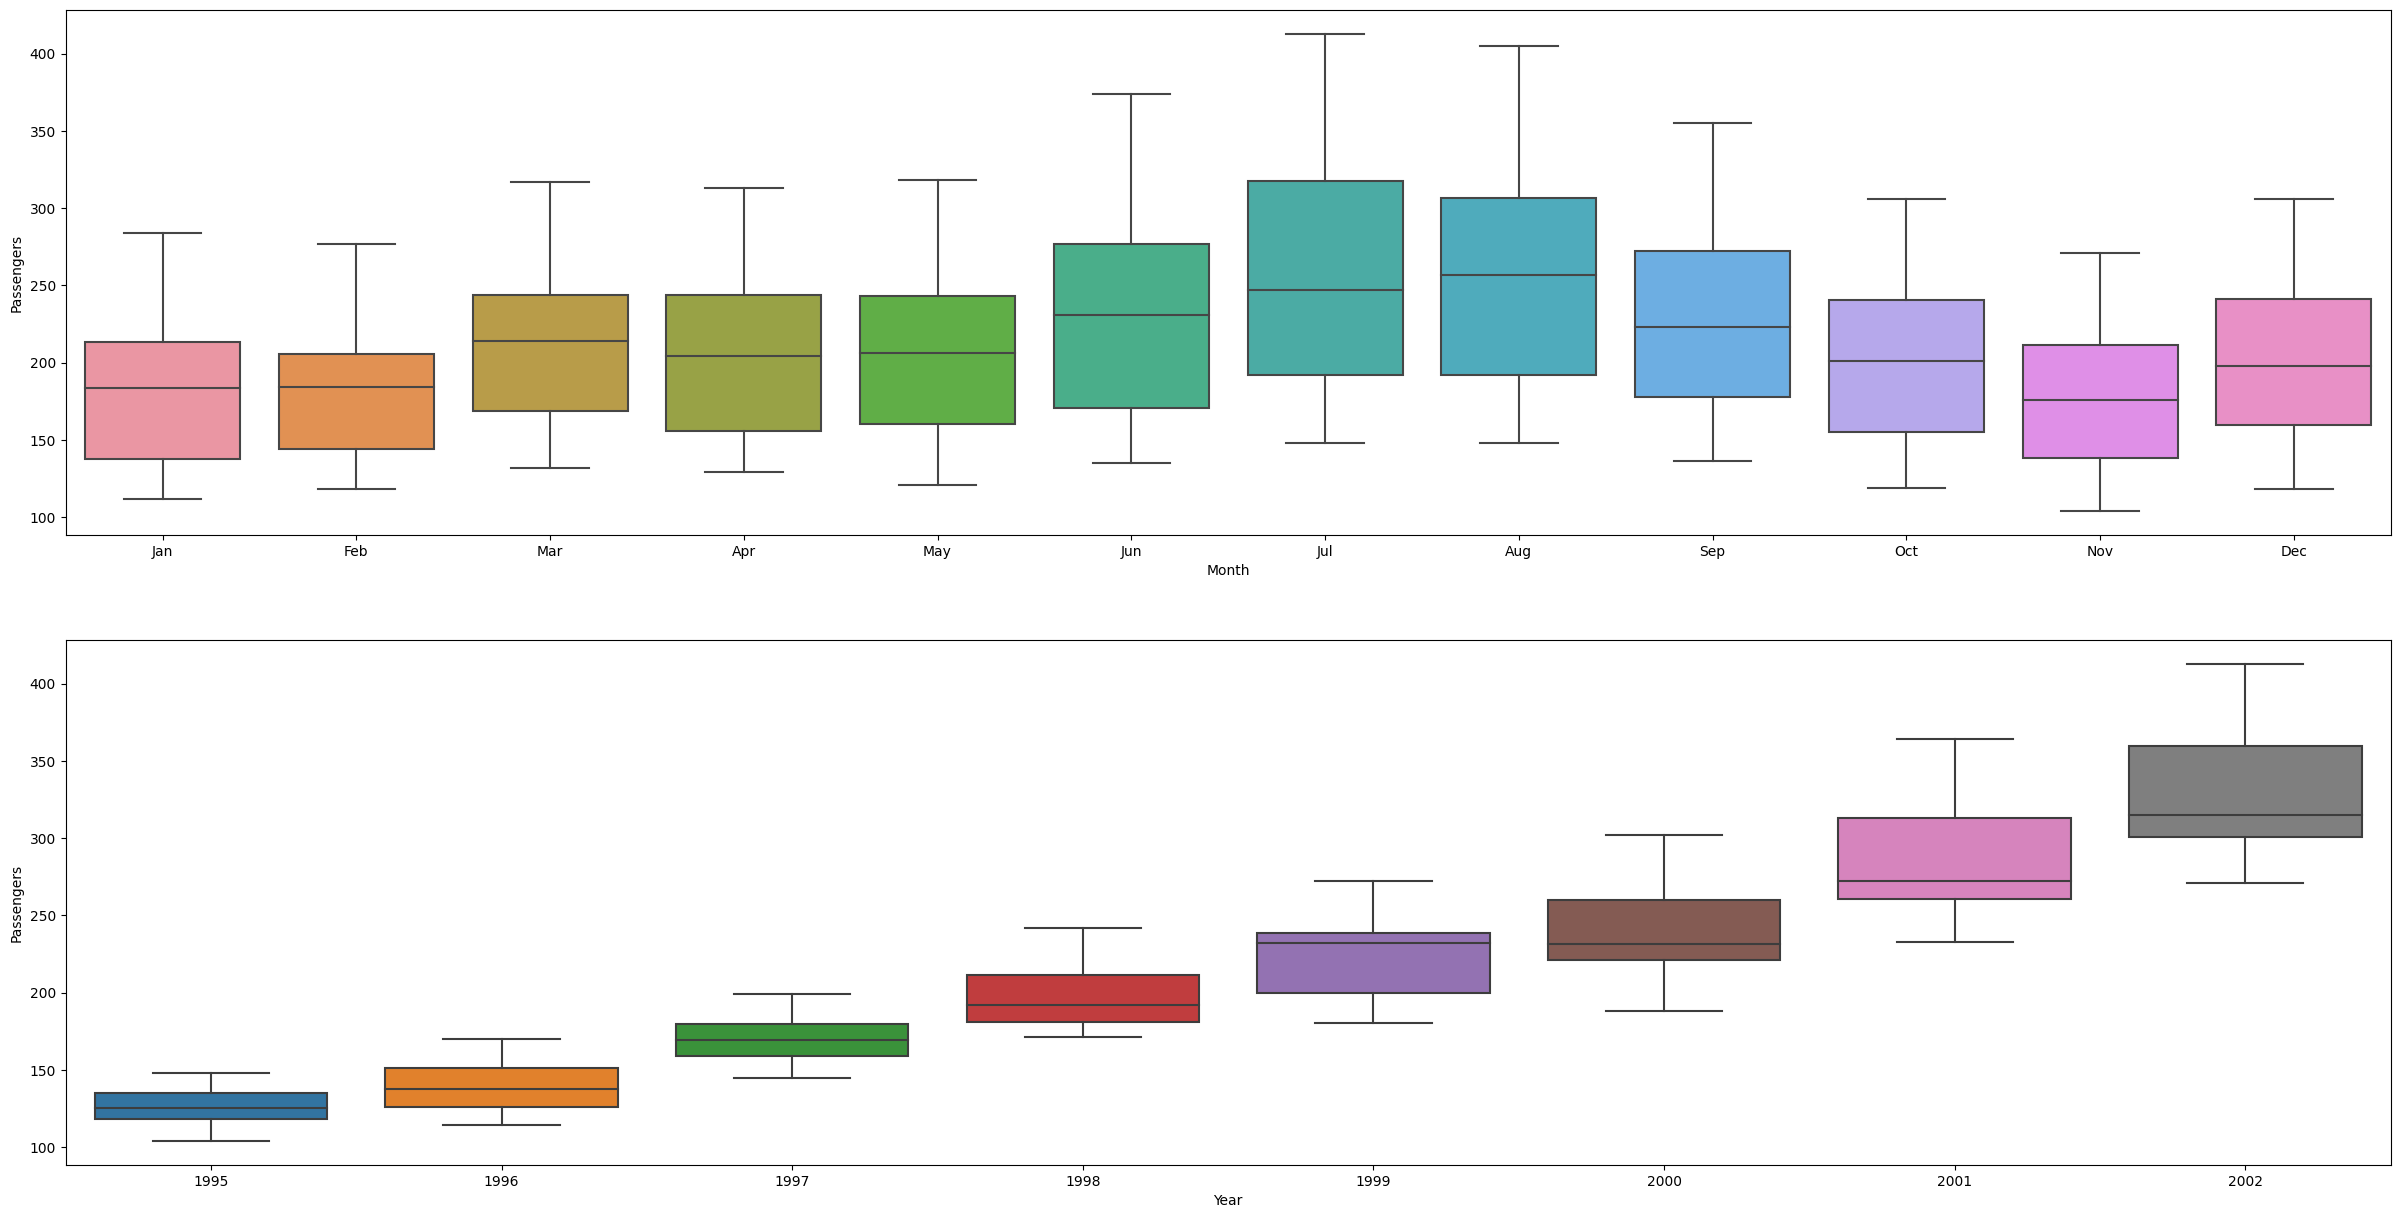

In [231]:
plt.figure(figsize=(30,15))
plt.subplot(211)
sn.boxplot(x="Month",y="Passengers",data=df)
plt.subplot(212)
sn.boxplot(x="Year",y="Passengers",data=df)

### Histogram

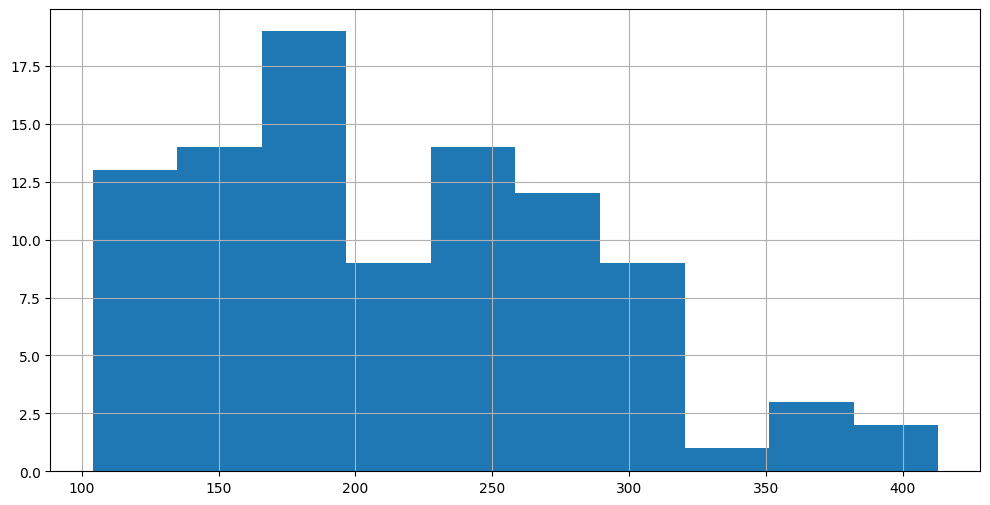

In [232]:
df.Passengers.hist(figsize=(12,6))
plt.show()

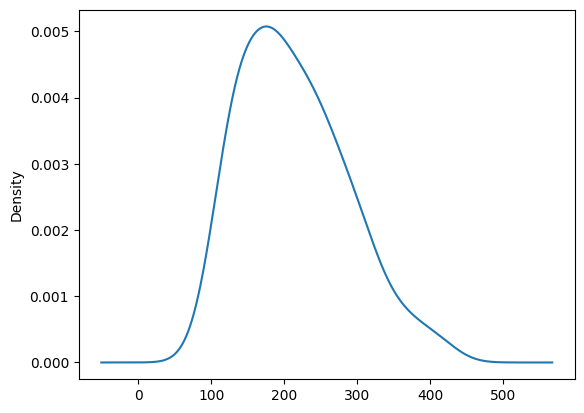

In [233]:
# create a density plot
df.Passengers.plot(kind='kde')
plt.show()

### Lag plot


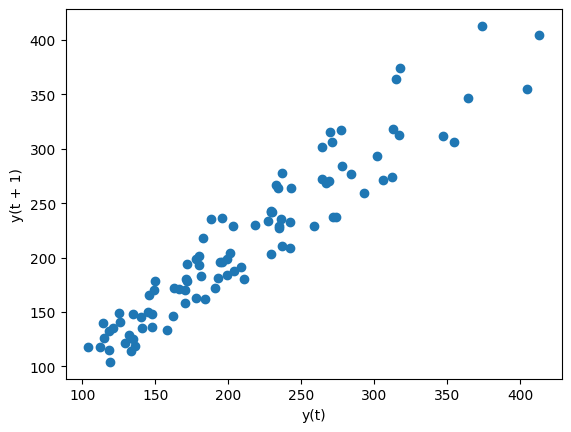

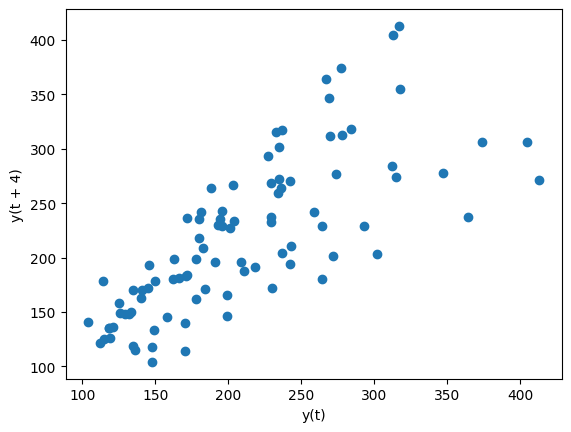

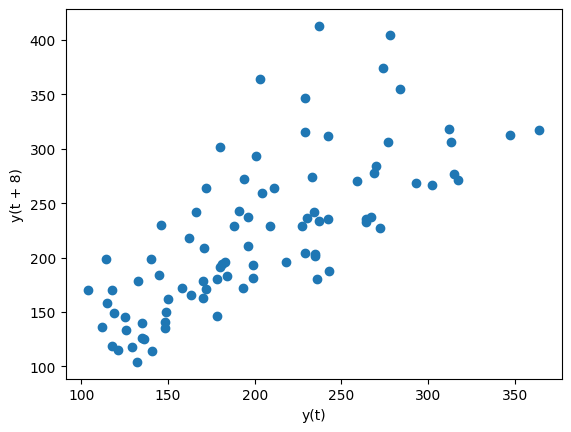

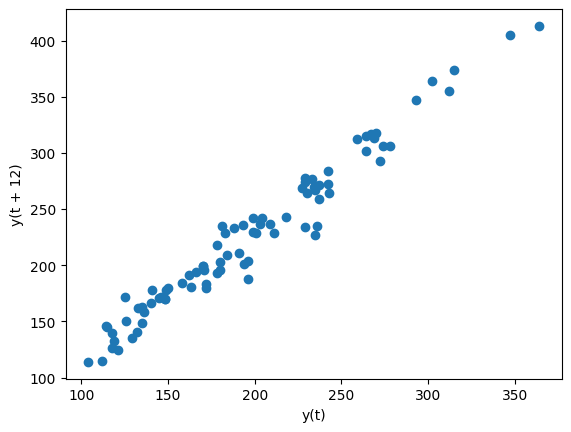

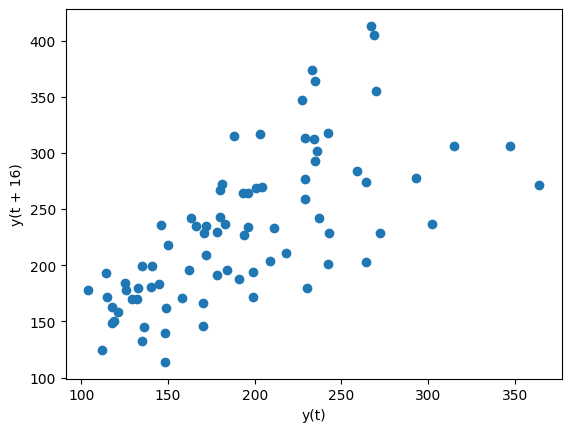

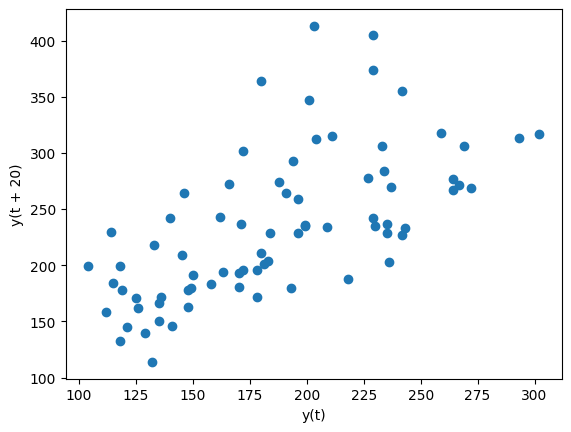

In [234]:
# create a scatter plot
for i in [1, 4, 8,12, 16, 20]:
    lag_plot(df.Passengers, lag=i)
    plt.show()


### Moving Average


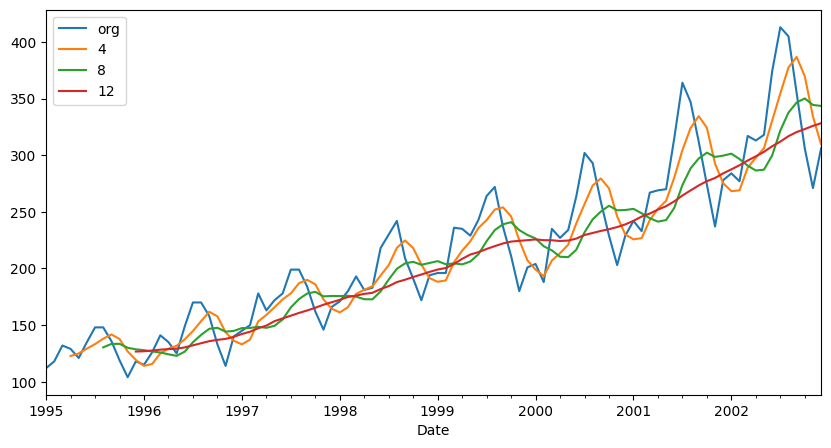

In [235]:
plt.figure(figsize=(10,5))
df.Passengers.plot(label="org")
for i in range(4,13,4):
    df["Passengers"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

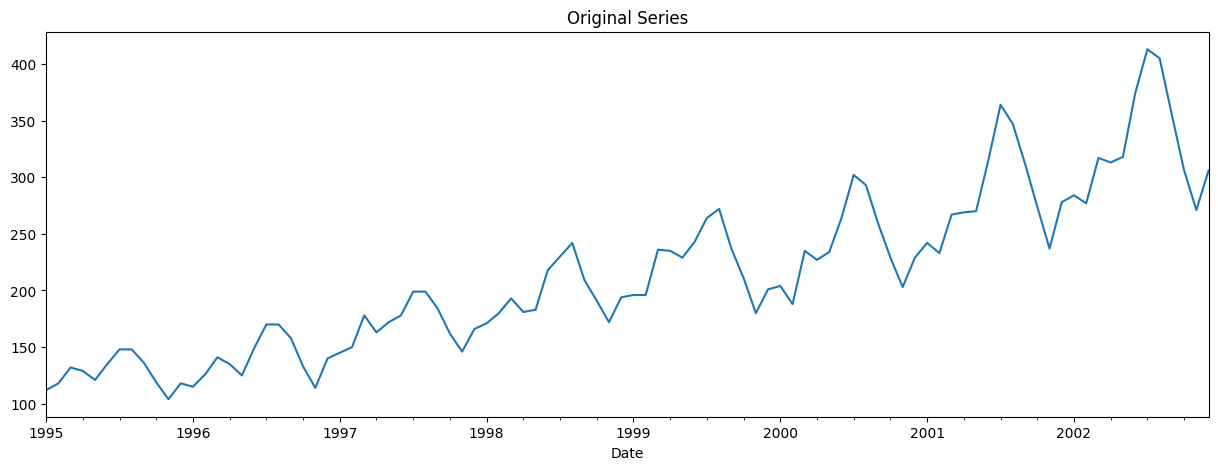

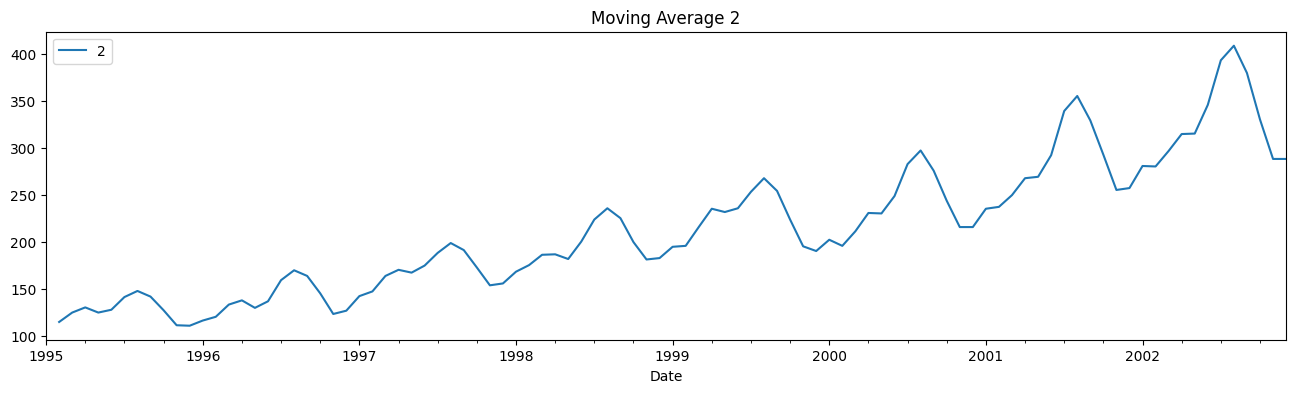

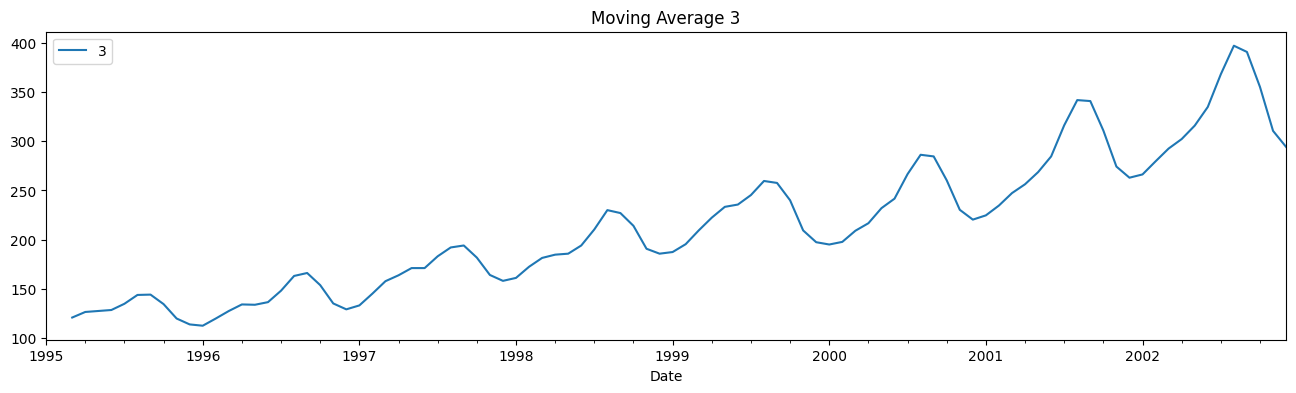

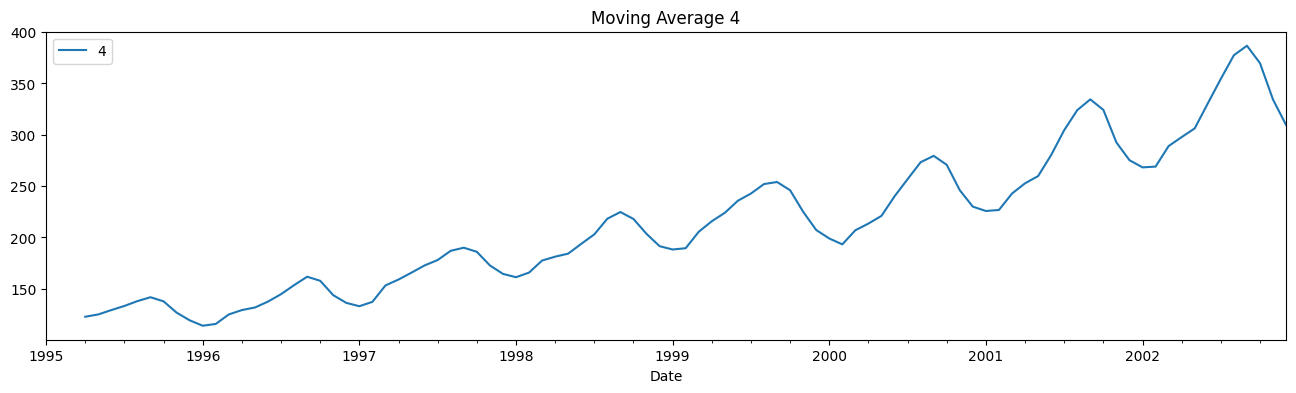

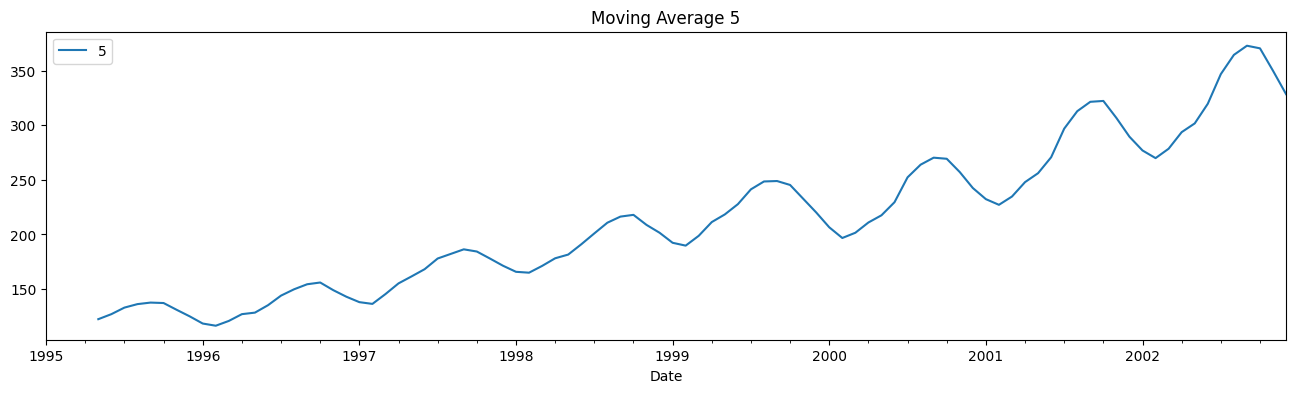

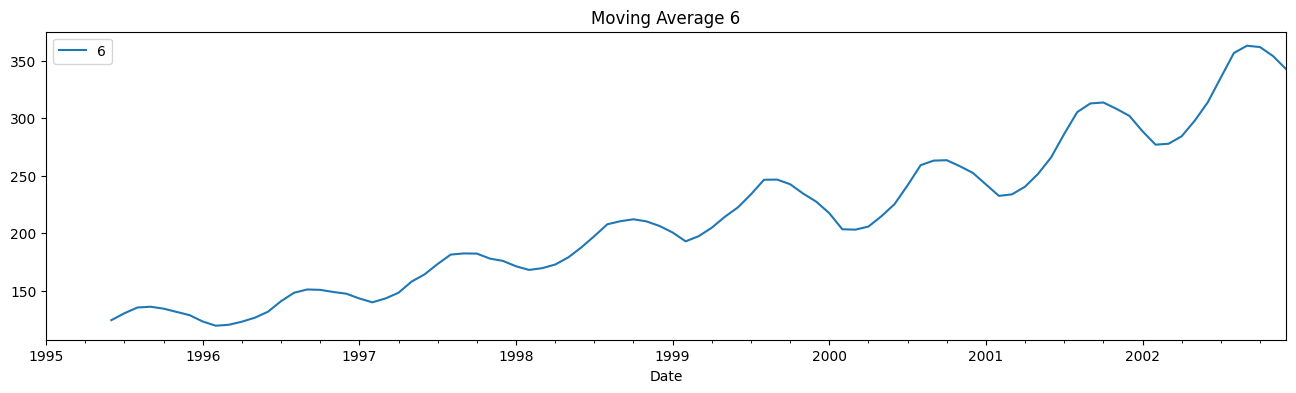

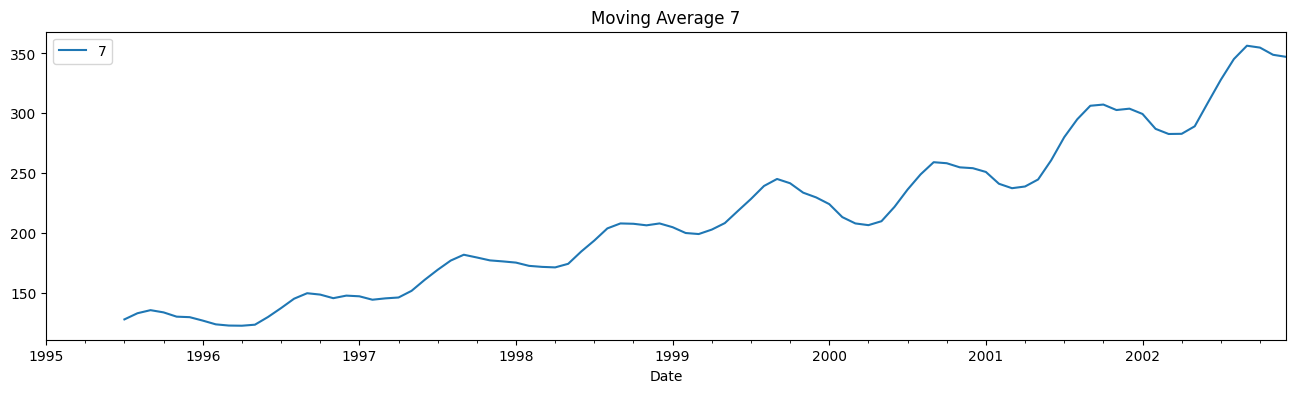

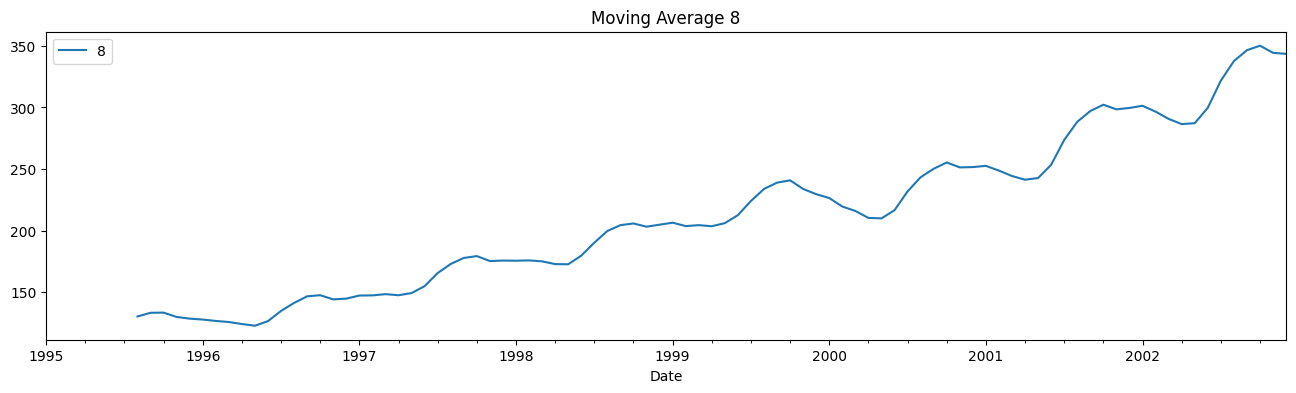

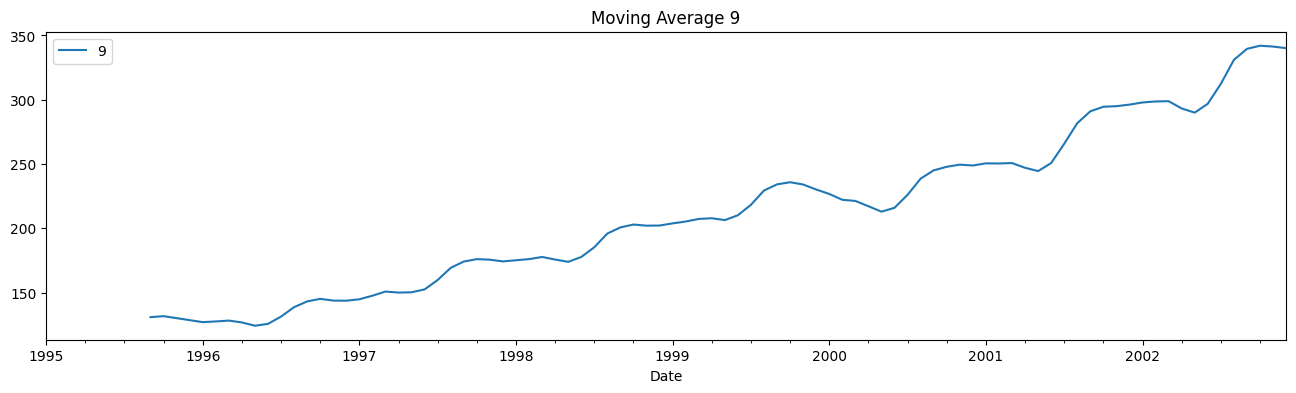

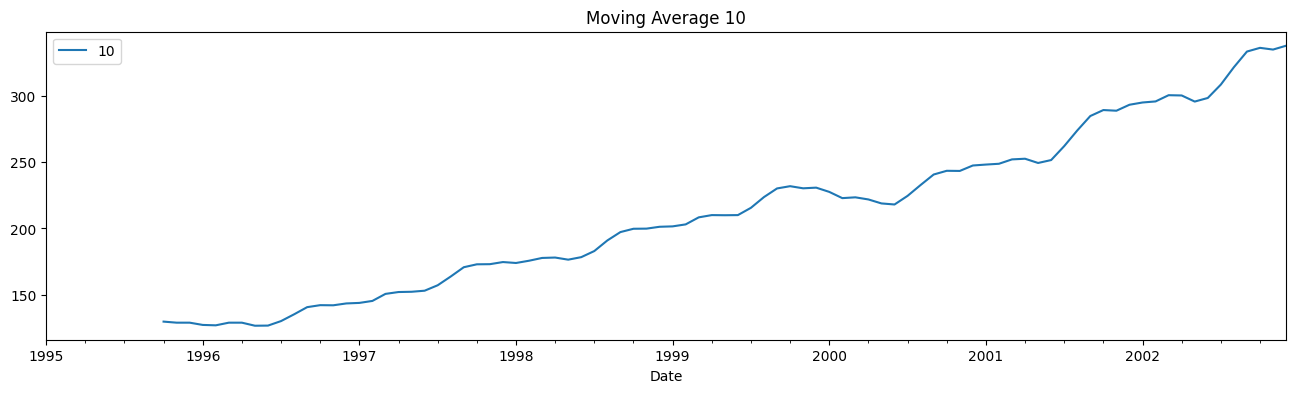

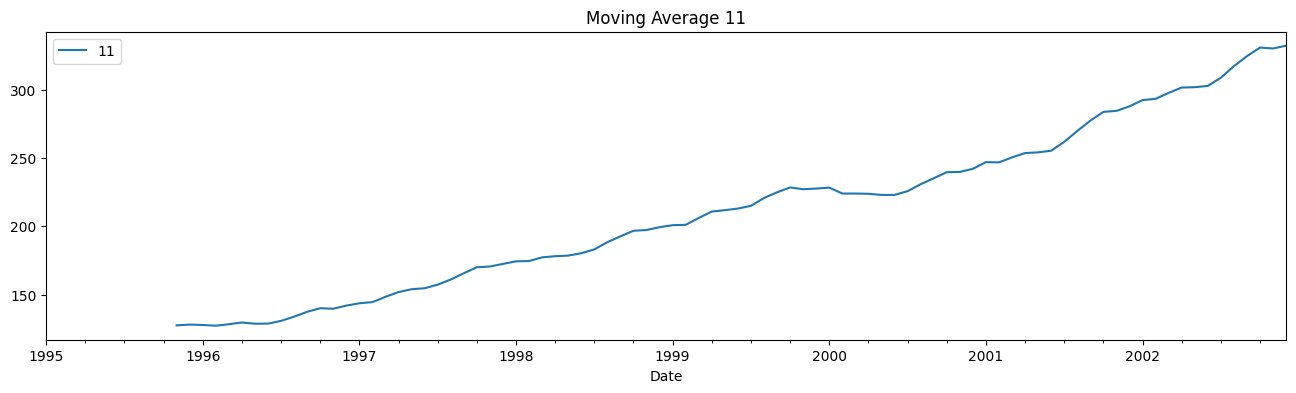

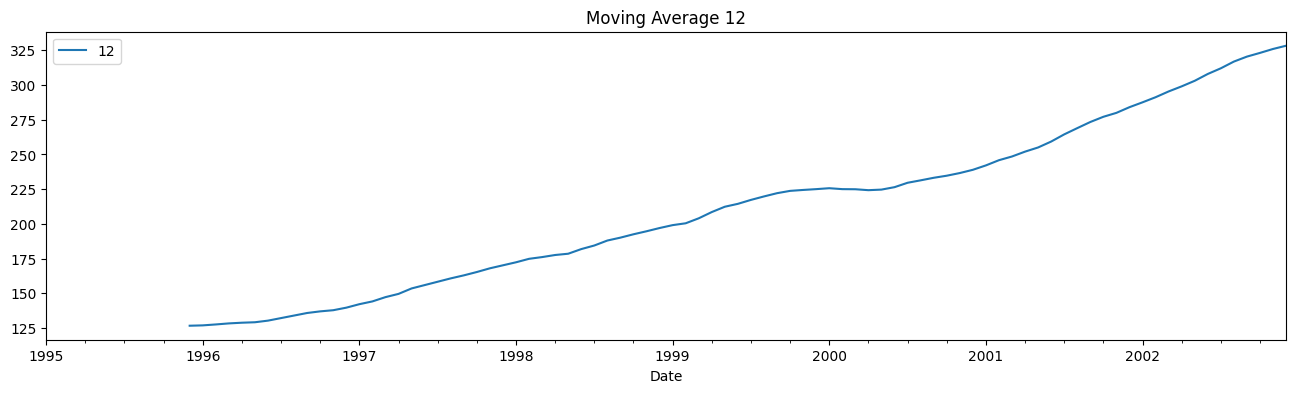

In [236]:
plt.figure(figsize=(15,5))

df.Passengers.plot(label="org")
plt.title("Original Series")

for i in range(2,13):
    plt.figure(figsize=(16,4))
    df["Passengers"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show()

### Time series decomposition plot


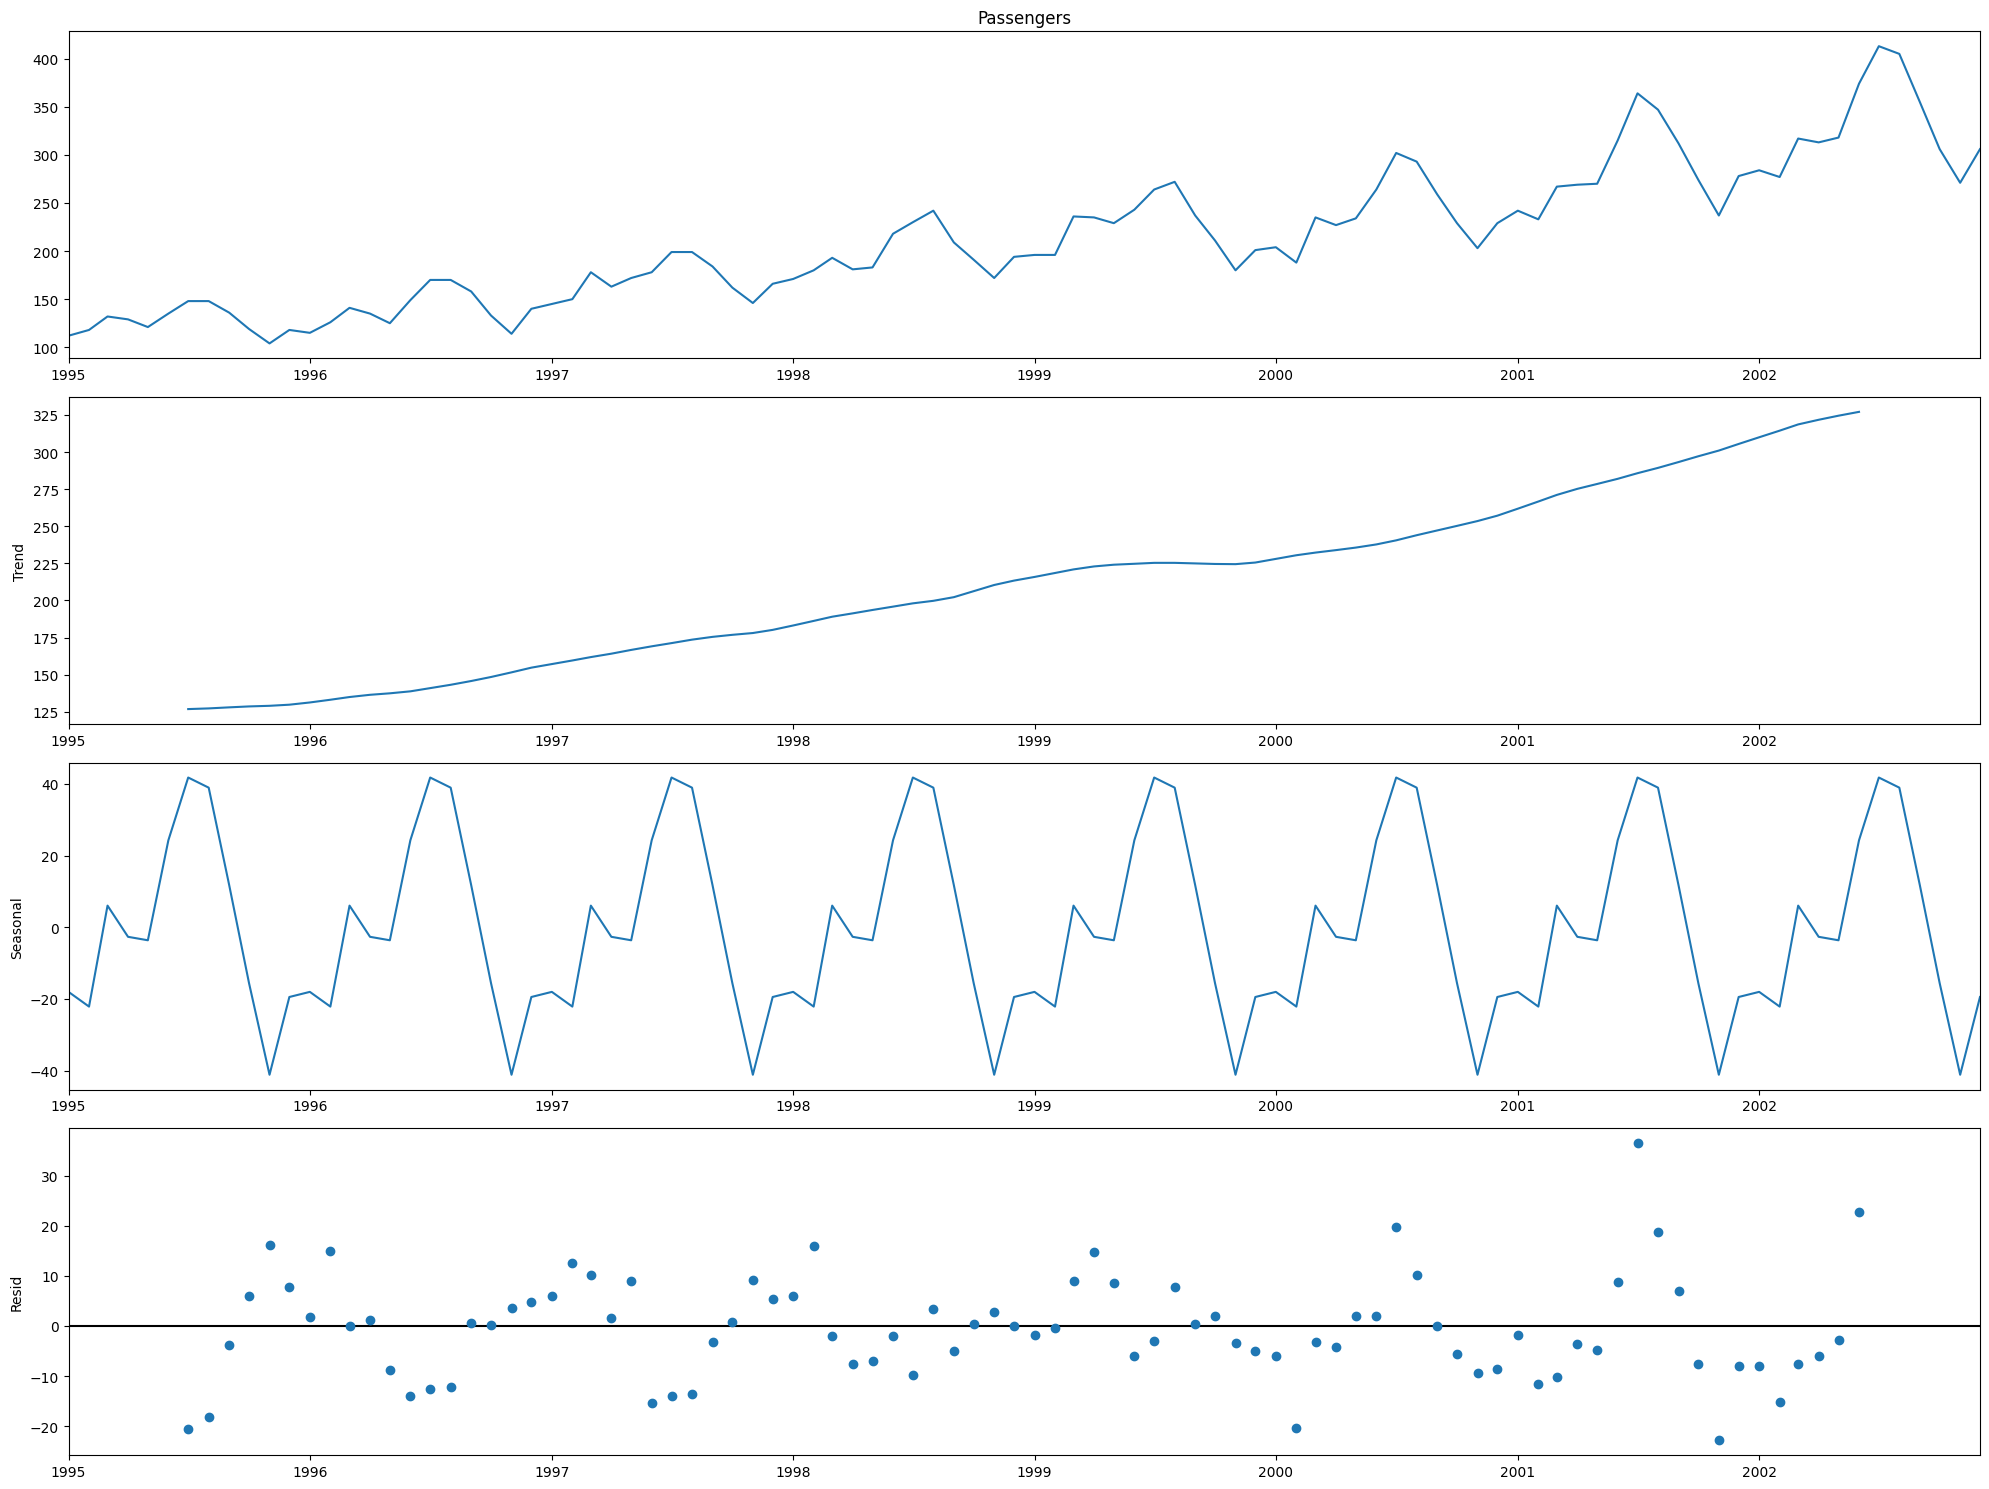

In [237]:
decompose_ts = seasonal_decompose(df.Passengers,period=12)
with plt.rc_context():
    plt.rc("figure", figsize=(20,15))
    decompose_ts.plot()
    plt.show()

## ACF plots and PACF plots
### Autocorrelation Function (ACF)
- The ACF is a statistical technique that we can use to identify how correlated the values in a time series are with each other.
- The ACF plots the correlation coefficient against the lag, which is measured in terms of a number of periods or units.
- A lag corresponds to a certain point in time after which we observe the first value in the time series.
- The correlation coefficient can range from -1 (a perfect negative relationship) to +1 (a perfect positive relationship). 

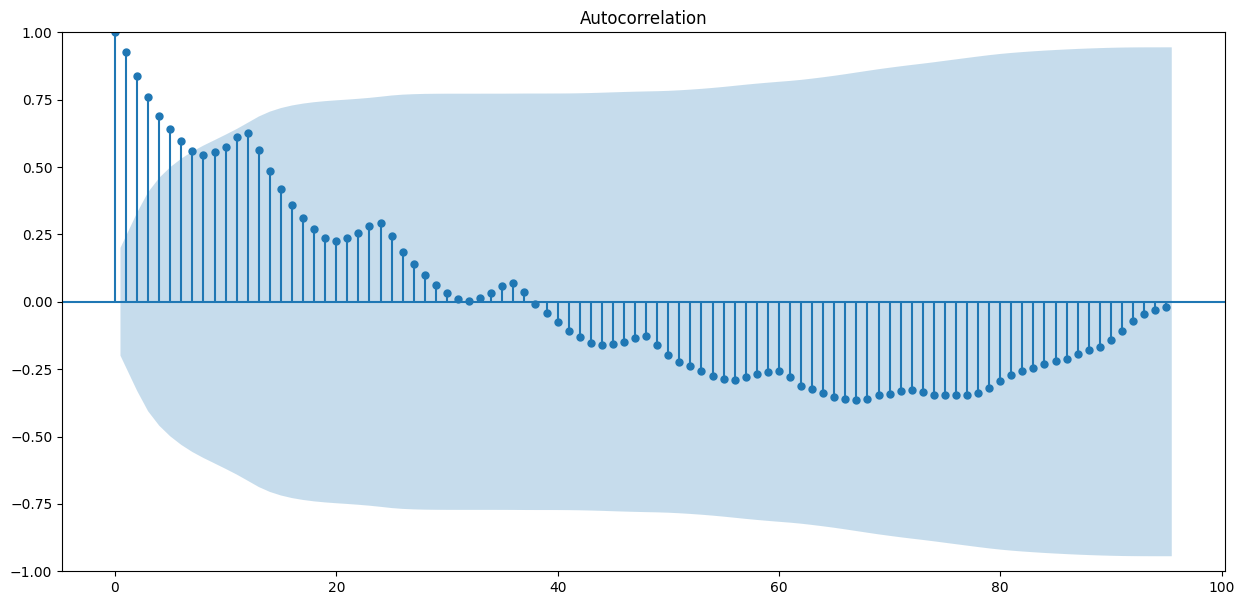

In [238]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(15,7))
    tsa_plots.plot_acf(df.Passengers,lags=95)
    plt.show()

**To summarize, autocorrelation is the correlation between a time series (signal) and a delayed version of itself, while the ACF plots the correlation coefficient against the lag, and it’s a visual representation of autocorrelation.**

### Partial Autocorrelation Function (PACF)
PACF is a statistical measure that captures the correlation between two variables after controlling for the effects of other variables.

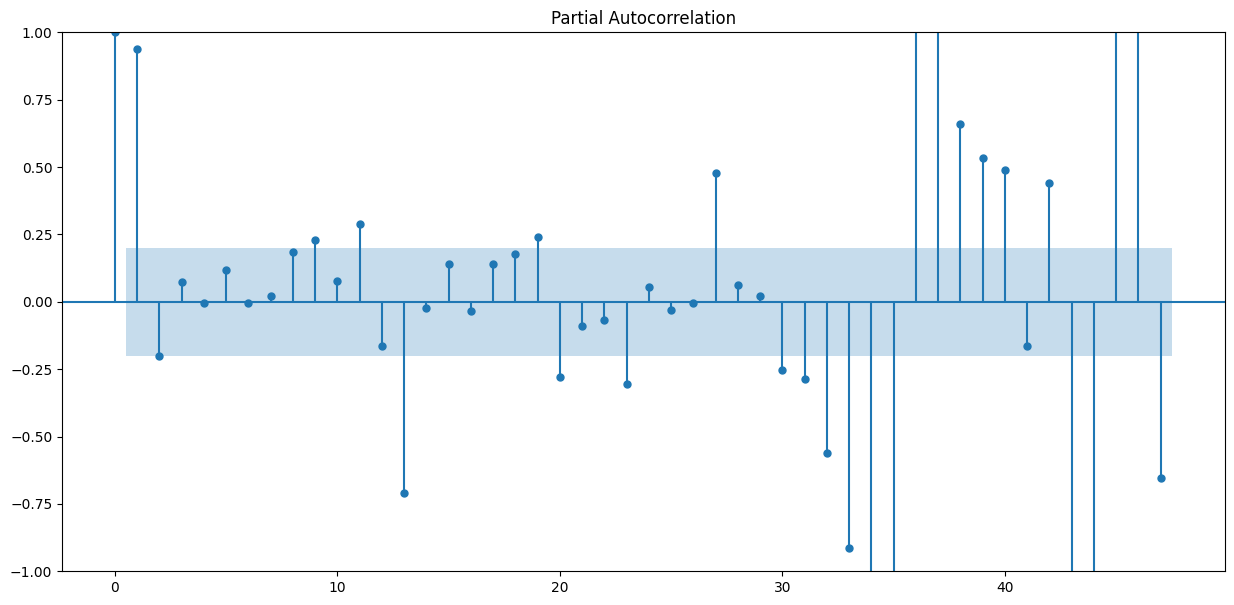

In [239]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(15,7))
    tsa_plots.plot_pacf(df.Passengers,lags=47)
    plt.show()

#### To summarize, a partial autocorrelation function captures a “direct” correlation between time series and a lagged version of itself.


In [240]:
df.head()

Passengers Month  Year
Date                              
1995-01-01         112   Jan  1995
1995-02-01         118   Feb  1995
1995-03-01         132   Mar  1995
1995-04-01         129   Apr  1995
1995-05-01         121   May  1995

In [248]:
df1= df.copy()

df1['date'] = pd.to_datetime(df1['Date'])
df1['year'] = df1['Date'].dt.year
df1['month'] = df1['Date'].dt.month
df1['week'] = df1['Date'].dt.isocalendar().week
df1['quarter'] = df1['Date'].dt.quarter
df1['day_of_week'] = df1['Date'].dt.day_name()

df1.set_index('Date',inplace=True)
df1.index.year


Int64Index([1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995,
            1995, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996,
            1996, 1996, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997,
            1997, 1997, 1997, 1998, 1998, 1998, 1998, 1998, 1998, 1998, 1998,
            1998, 1998, 1998, 1998, 1999, 1999, 1999, 1999, 1999, 1999, 1999,
            1999, 1999, 1999, 1999, 1999, 2000, 2000, 2000, 2000, 2000, 2000,
            2000, 2000, 2000, 2000, 2000, 2000, 2001, 2001, 2001, 2001, 2001,
            2001, 2001, 2001, 2001, 2001, 2001, 2001, 2002, 2002, 2002, 2002,
            2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002],
           dtype='int64', name='Date')

In [244]:
df1.head(10)

Passengers Month  Year       date  year  month  week  quarter  \
Date                                                                        
1995-01-01         112   Jan  1995 1995-01-01  1995      1    52        1   
1995-02-01         118   Feb  1995 1995-02-01  1995      2     5        1   
1995-03-01         132   Mar  1995 1995-03-01  1995      3     9        1   
1995-04-01         129   Apr  1995 1995-04-01  1995      4    13        2   
1995-05-01         121   May  1995 1995-05-01  1995      5    18        2   
1995-06-01         135   Jun  1995 1995-06-01  1995      6    22        2   
1995-07-01         148   Jul  1995 1995-07-01  1995      7    26        3   
1995-08-01         148   Aug  1995 1995-08-01  1995      8    31        3   
1995-09-01         136   Sep  1995 1995-09-01  1995      9    35        3   
1995-10-01         119   Oct  1995 1995-10-01  1995     10    39        4   

           day_of_week  
Date                    
1995-01-01      Sunday  
1995-02-01   Wednesday  
1995-03-01   Wednesday  
1995-04-01    Saturday  
1995-05-01      Monday  
1995-06-01    Thursday  
1995-07-01    Saturday  
1995-08-01     Tuesday  
1995-09-01      Friday  
1995-10-01      Sunday

In [245]:
df1.year.unique()

array([1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002], dtype=int64)


# Time Series Decomposition

## Additive Seasonal Decomposition


In [246]:
df1

Passengers Month  Year       date  year  month  week  quarter  \
Date                                                                        
1995-01-01         112   Jan  1995 1995-01-01  1995      1    52        1   
1995-02-01         118   Feb  1995 1995-02-01  1995      2     5        1   
1995-03-01         132   Mar  1995 1995-03-01  1995      3     9        1   
1995-04-01         129   Apr  1995 1995-04-01  1995      4    13        2   
1995-05-01         121   May  1995 1995-05-01  1995      5    18        2   
...                ...   ...   ...        ...   ...    ...   ...      ...   
2002-08-01         405   Aug  2002 2002-08-01  2002      8    31        3   
2002-09-01         355   Sep  2002 2002-09-01  2002      9    35        3   
2002-10-01         306   Oct  2002 2002-10-01  2002     10    40        4   
2002-11-01         271   Nov  2002 2002-11-01  2002     11    44        4   
2002-12-01         306   Dec  2002 2002-12-01  2002     12    48        4   

           day_of_week  
Date                    
1995-01-01      Sunday  
1995-02-01   Wednesday  
1995-03-01   Wednesday  
1995-04-01    Saturday  
1995-05-01      Monday  
...                ...  
2002-08-01    Thursday  
2002-09-01      Sunday  
2002-10-01     Tuesday  
2002-11-01      Friday  
2002-12-01      Sunday  

[96 rows x 9 columns]

In [247]:
df1.set_index('Date',inplace=True)
df1.index.year

KeyError: "None of ['Date'] are in the columns"

In [ ]:
decompose_ts_add = seasonal_decompose(df1.Passengers,period=12, model='additive')
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

**Seasonal** -
- Varies from +40 to -20 with the mean 0.
- Each cycle represents each year trend.
- The value in the Y-axis has to be added to the Trend plot value to get the actual value of that year. 
- E.g.:- For the year 1950 Nov, the seasonal value is +50 and the trend value is 100. 
- Hence, the actual value(passengers number) will (seasonal+Trend) value = 50+100 = 150.


### Multiplicative Seasonal Decomposition


In [ ]:
decompose_mul = seasonal_decompose(df1.Passengers,period=12, model='multiplicative')
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_mul.plot()
    plt.show()

**Seasonal** -
- Varies from 0.8 to 1.2
- The value in the Y-axis has to be multiplied to the Trend plot value to get the actual value of that year.
- E.g.:- For the year 1950 Nov, the seasonal value is 1.2 and the trend value is 100. 
- Hence, the actual value(passengers number) will (seasonal X Trend) value = 1.2 X 100 = 120.

## Splitting Train and Test Data
### Leaving Test Data with 2 Years of Time Series


In [249]:
size = 72
train_df = df1[:size]
test_df = df1[size:]
print('Train:',train_df.index.min(),train_df.index.max())
print('Test:',test_df.index.min(),test_df.index.max())

Train: 1995-01-01 00:00:00 2000-12-01 00:00:00
Test: 2001-01-01 00:00:00 2002-12-01 00:00:00


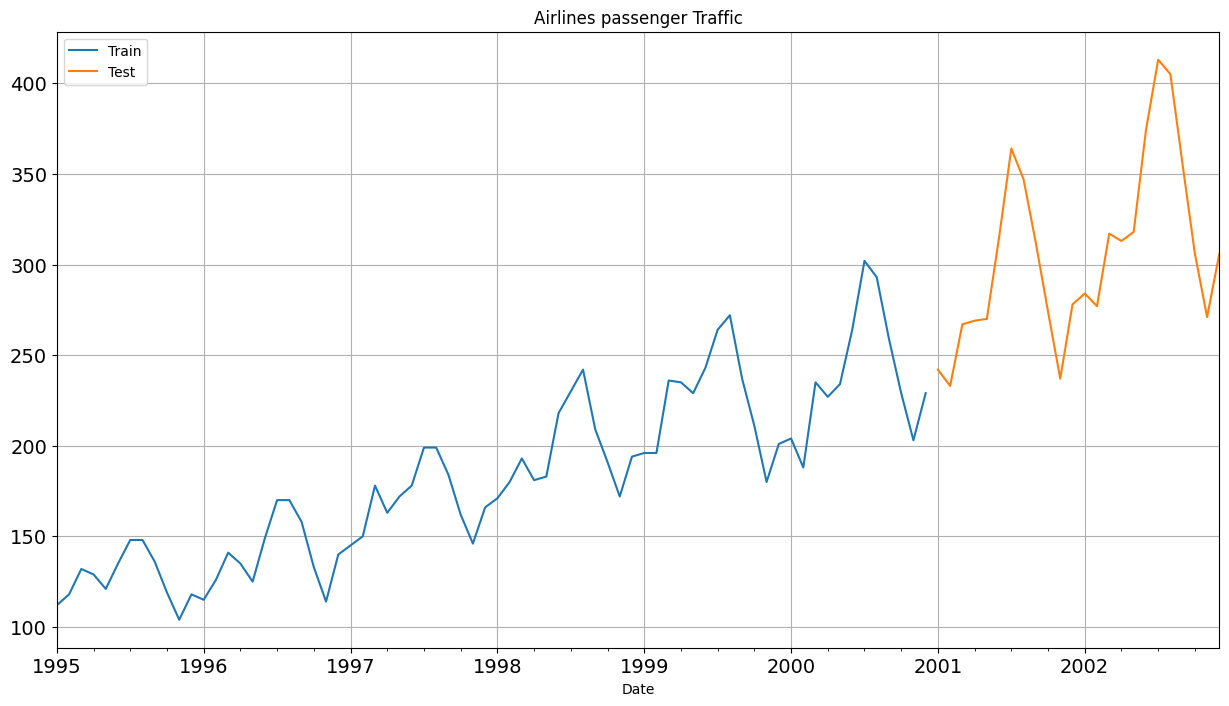

In [250]:
train_df.Passengers.plot(figsize=(15,8), title= 'Airlines passenger Traffic', fontsize=14, label='Train')
test_df.Passengers.plot(figsize=(15,8), title= 'Airlines passenger Traffic', fontsize=14, label='Test')
plt.legend()
plt.grid()
plt.show()

### Evaluation Metric MAPE


In [251]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

## Exponential Methods
### Simple Exponential Method
### Using Forecast Attribute


In [252]:
ses_model = SimpleExpSmoothing(train_df['Passengers']).fit(optimized=True)
test_pred_ses = ses_model.forecast(24)
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = sqrt(mean_squared_error(test_pred_ses,test_df.Passengers))
train_rmse_ses = sqrt(mean_squared_error(train_pred_ses,train_df.Passengers))
mape_ses = MAPE(test_pred_ses,test_df.Passengers)

print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ses),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ses),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ses))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error = 23.38228335004595 
 Train Root Mean Squared Error = 19.03177173091145 
 Test Root Mean Squared Error = 91.11325402904713


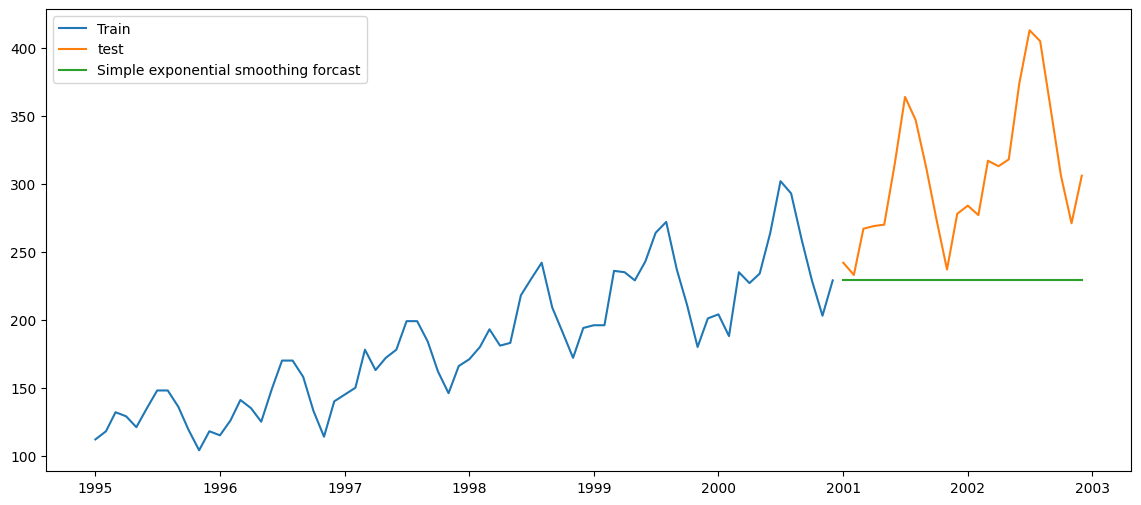

In [253]:
plt.figure(figsize=(14,6))
plt.plot(train_df.Passengers, label='Train')
plt.plot(test_df.Passengers, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

- No seasonality captures.
- Most recent observation gets higher weightages than the older ones for forecasting.

### Holt method (Double Exponential)
**It Captures both Level and Trend.**


In [254]:
dexp_model  = Holt(train_df['Passengers']).fit(optimized=True)
test_pred_dexp = dexp_model.forecast(24)
train_pred_dexp = dexp_model.fittedvalues
test_rmse_dexp = sqrt(mean_squared_error(test_pred_dexp,test_df.Passengers))
train_rmse_dexp = sqrt(mean_squared_error(train_pred_dexp,train_df.Passengers))
mape_dexp = MAPE(test_pred_dexp,test_df.Passengers)
print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_dexp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_dexp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_dexp))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error = 17.149025584030046 
 Train Root Mean Squared Error = 18.961289994538912 
 Test Root Mean Squared Error = 71.6347776288056


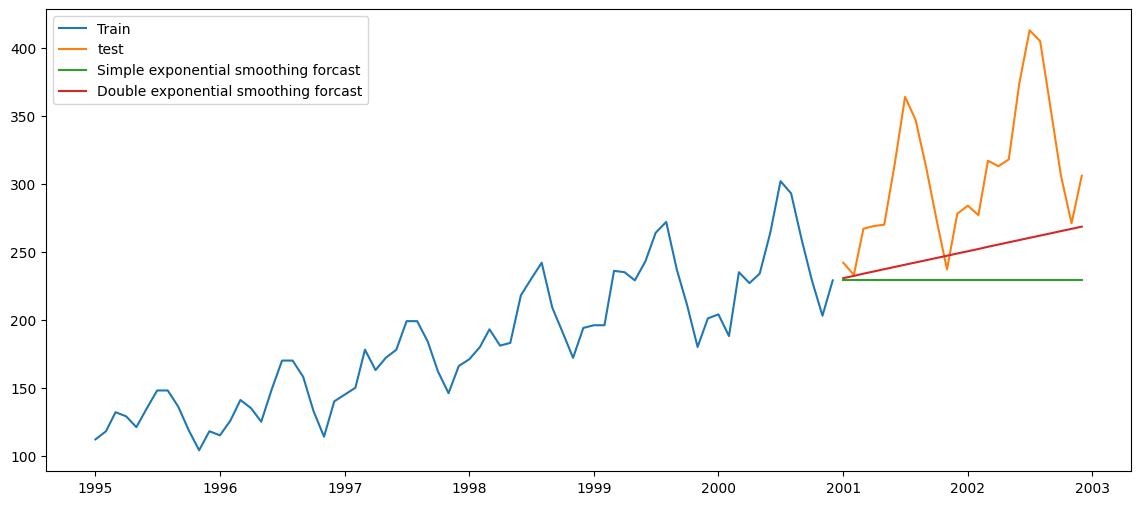

In [255]:
plt.figure(figsize=(14,6))
plt.plot(train_df.Passengers, label='Train')
plt.plot(test_df.Passengers, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

- We can see that it capture the trend of the data.
- We were not able to capture the seasonality.

## Holts winter exponential smoothing with additive seasonality and trend (Triple Exponential)
**It Captures Level, Trend and Seasonality.**


In [256]:
texp_add_model  = ExponentialSmoothing(train_df.Passengers,seasonal="add",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_ad = texp_add_model.forecast(24)
train_pred_ad = texp_add_model.fittedvalues
test_rmse_ad = sqrt(mean_squared_error(test_pred_ad,test_df.Passengers))
train_rmse_ad = sqrt(mean_squared_error(train_pred_ad,train_df.Passengers))
mape_ad = MAPE(test_pred_ad,test_df.Passengers)
print('Triple Exponential with Additive Trend and Seosonality Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ad),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ad))


Triple Exponential with Additive Trend and Seosonality Method Evaluation 
 Mean Absolute Percent Error = 12.084270987248688 
 Train Root Mean Squared Error = 7.751303510644329 
 Test Root Mean Squared Error = 47.56853148096913


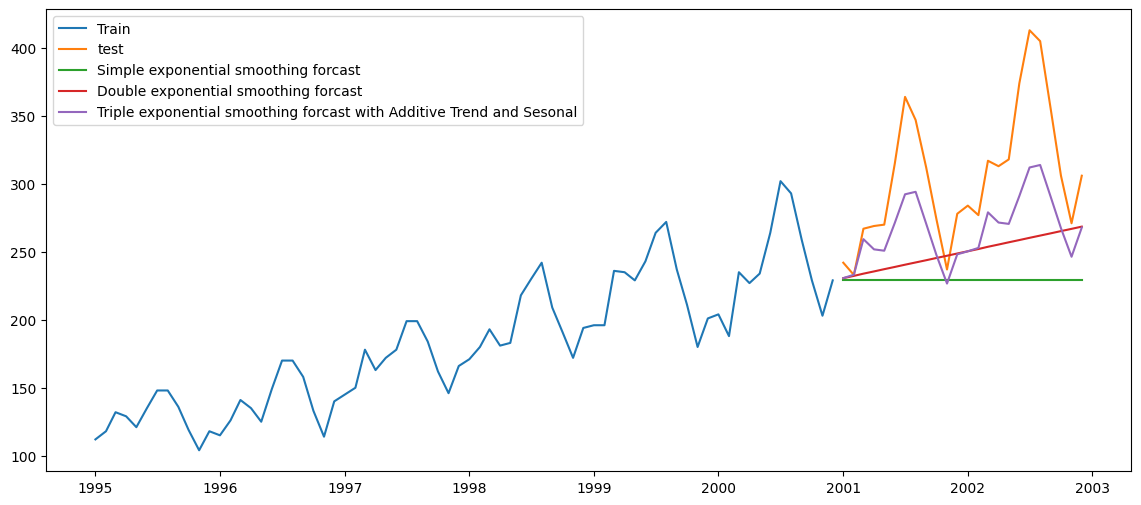

In [257]:
plt.figure(figsize=(14,6))
plt.plot(train_df.Passengers, label='Train')
plt.plot(test_df.Passengers, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.legend(loc='best')
plt.show()

### Holts winter exponential smoothing with multiplicative seasonality and additive trend (Triple Exponential).


In [258]:
texp_mul_ad_model  = ExponentialSmoothing(train_df.Passengers,seasonal="mul",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_mul_ad_texp = texp_mul_ad_model.forecast(24)
train_pred_mul_ad_texp = texp_mul_ad_model.fittedvalues
test_rmse_mul_ad_texp = sqrt(mean_squared_error(test_pred_mul_ad_texp,test_df.Passengers))
train_rmse_mul_ad_texp = sqrt(mean_squared_error(train_pred_mul_ad_texp,train_df.Passengers))
mape_mul_ad_texp = MAPE(test_pred_mul_ad_texp,test_df.Passengers)
print('Triple Exponential Method with Multiplicative Seasonality and Additive Trend',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_mul_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_ad_texp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_mul_ad_texp))


Triple Exponential Method with Multiplicative Seasonality and Additive Trend 
 Mean Absolute Percent Error = 9.368507048672798 
 Train Root Mean Squared Error = 6.386634437545614 
 Test Root Mean Squared Error = 34.989900508860515


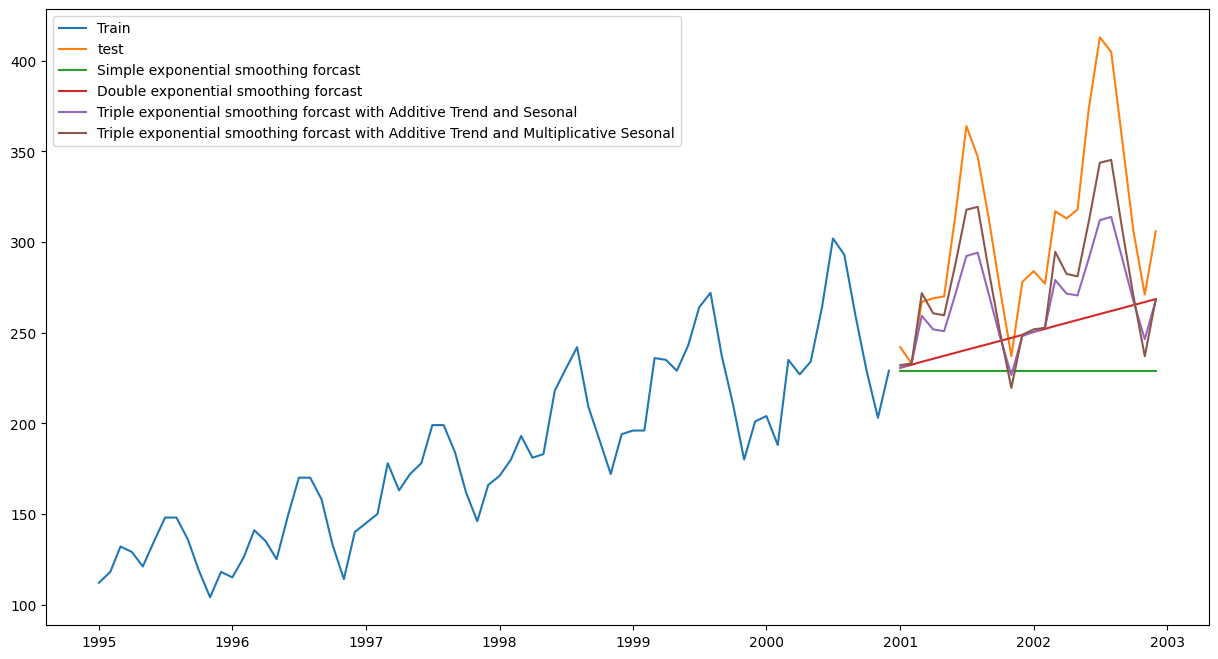

In [259]:
plt.figure(figsize=(15,8))
plt.plot(train_df.Passengers, label='Train')
plt.plot(test_df.Passengers, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.legend(loc='best')
plt.show()

### Holts winter exponential smoothing with Additive seasonality and multiplicative trend (Triple Exponential)


In [260]:
texp_ad_mul_model  = ExponentialSmoothing(train_df.Passengers,seasonal="add",trend="mul",seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.5)
test_pred_ad_mul_texp  = texp_ad_mul_model.forecast(24)
train_pred_ad_mul_texp  = texp_ad_mul_model.fittedvalues
test_rmse_ad_mul_texp  = sqrt(mean_squared_error(test_pred_ad_mul_texp ,test_df.Passengers))
train_rmse_ad_mul_texp  = sqrt(mean_squared_error(train_pred_ad_mul_texp ,train_df.Passengers))
mape_ad_mul_texp  = MAPE(test_pred_ad_mul_texp,test_df.Passengers)
print('Triple Exponential Method with Additive Seasonality and Multiplicative Trend',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ad_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_mul_texp ),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ad_mul_texp ))


Triple Exponential Method with Additive Seasonality and Multiplicative Trend 
 Mean Absolute Percent Error = 12.720038697644114 
 Train Root Mean Squared Error = 12.745961849041036 
 Test Root Mean Squared Error = 45.89160554538598


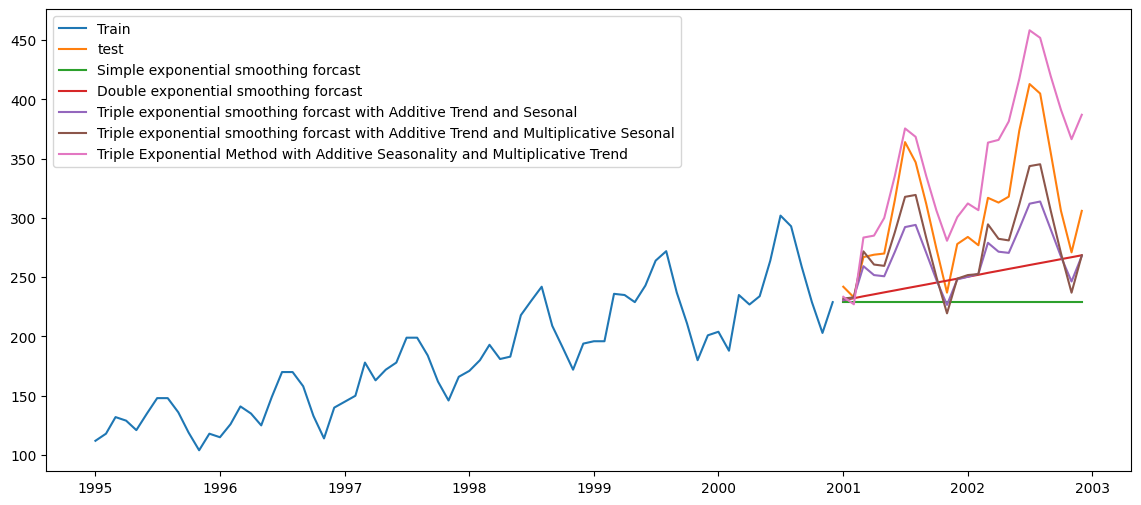

In [261]:
plt.figure(figsize=(14,6))
plt.plot(train_df.Passengers, label='Train')
plt.plot(test_df.Passengers, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.legend(loc='best')
plt.show()

### Holts winter exponential smoothing with multiplicative seasonality and multiplicative trend (Triple Exponential)


In [262]:
texp_mul_model  = ExponentialSmoothing(train_df.Passengers,seasonal="mul",trend="mul",seasonal_periods=12).fit(optimized=True)
test_pred_mul_texp  = texp_mul_model.forecast(24)
train_pred_mul_texp  = texp_mul_model.fittedvalues
test_rmse_mul_texp  = sqrt(mean_squared_error(test_pred_mul_texp ,test_df.Passengers))
train_rmse_mul_texp  = sqrt(mean_squared_error(train_pred_mul_texp ,train_df.Passengers))
mape_mul_texp  = MAPE(test_pred_mul_texp,test_df.Passengers)
print('Triple Exponential Method with multiplicative Trend and Seasonality',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_texp ),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_mul_texp ))


Triple Exponential Method with multiplicative Trend and Seasonality 
 Mean Absolute Percent Error = 6.0350676966147025 
 Train Root Mean Squared Error = 6.396749788058414 
 Test Root Mean Squared Error = 23.058820548001385


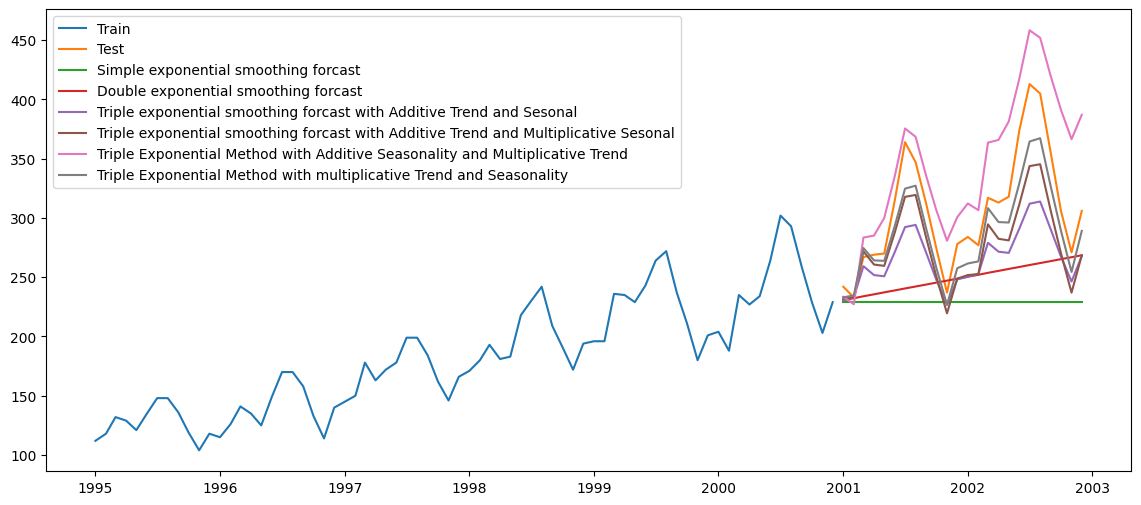

In [263]:
plt.figure(figsize=(14,6))
plt.plot(train_df.Passengers, label='Train')
plt.plot(test_df.Passengers, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.plot(test_pred_mul_texp, label='Triple Exponential Method with multiplicative Trend and Seasonality')
plt.legend(loc='best')
plt.show()

In [264]:
#Comparing the results 

Evaluation = {"Models":pd.Series(["Simple_Exp","Double_Exp","Triple_Exp_ad","Triple_Exp_mul_ad","Triple_Exp_ad_mul"\
                                  ,"Triple_Exp_mul"]),\
        "Train_RMSE":pd.Series([train_rmse_ses,train_rmse_dexp,train_rmse_ad,train_rmse_mul_ad_texp,train_rmse_ad_mul_texp,train_rmse_mul_texp]),\
        "Test_MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp]),\
        "Test_RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['Test_MAPE(%)'], inplace=True, ignore_index=True)
table_evaluation

Models  Train_RMSE  Test_MAPE(%)  Test_RMSE_Values
0     Triple_Exp_mul    6.396750      6.035068         23.058821
1  Triple_Exp_mul_ad    6.386634      9.368507         34.989901
2      Triple_Exp_ad    7.751304     12.084271         47.568531
3  Triple_Exp_ad_mul   12.745962     12.720039         45.891606
4         Double_Exp   18.961290     17.149026         71.634778
5         Simple_Exp   19.031772     23.382283         91.113254

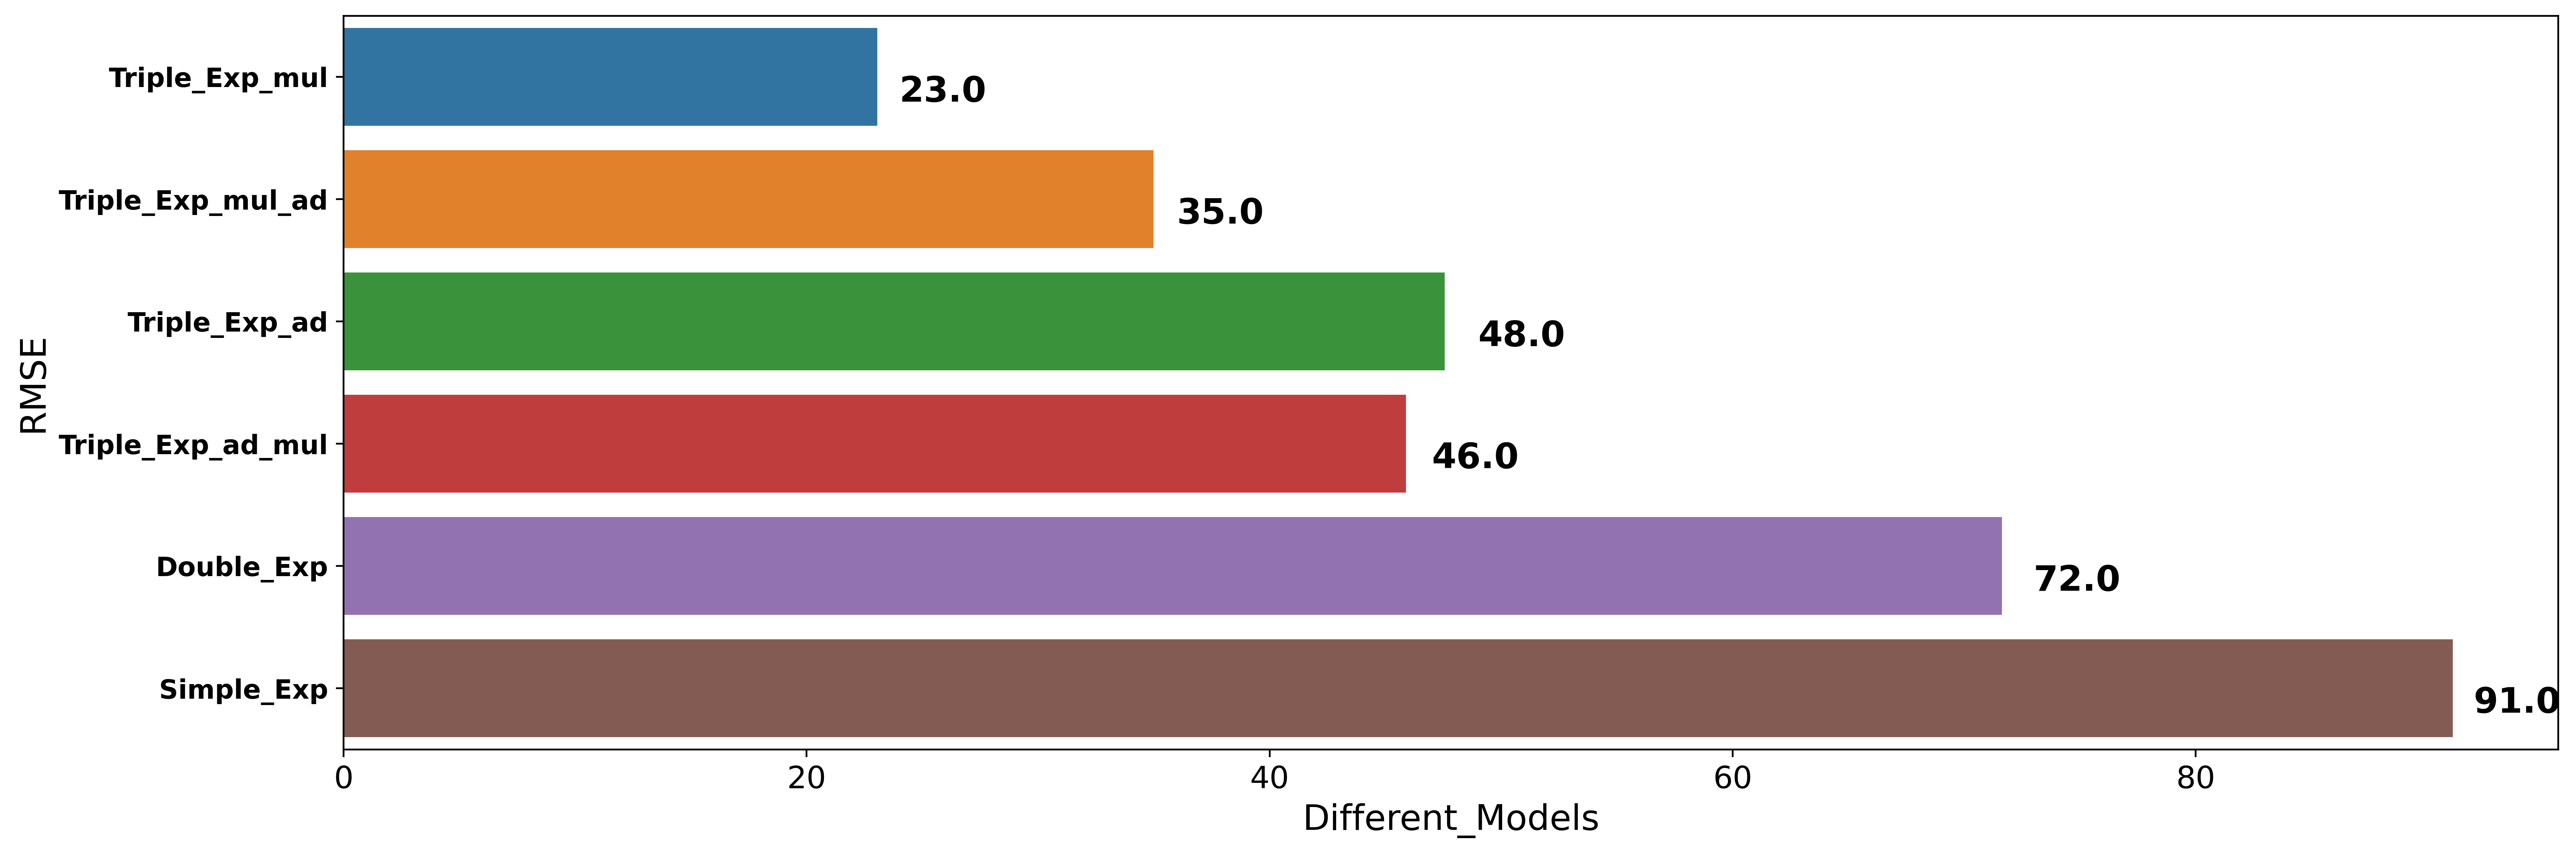

In [265]:
f, axe = plt.subplots(1,1, figsize=(18,6), dpi=500)
sn.barplot(x='Test_RMSE_Values', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=14)


for i, v in enumerate(np.round(table_evaluation.Test_RMSE_Values.values,0)):
    axe.text(v + 1, i + .20, str(v),
            color = 'black', fontweight = 'bold', fontsize= 16)

plt.show()

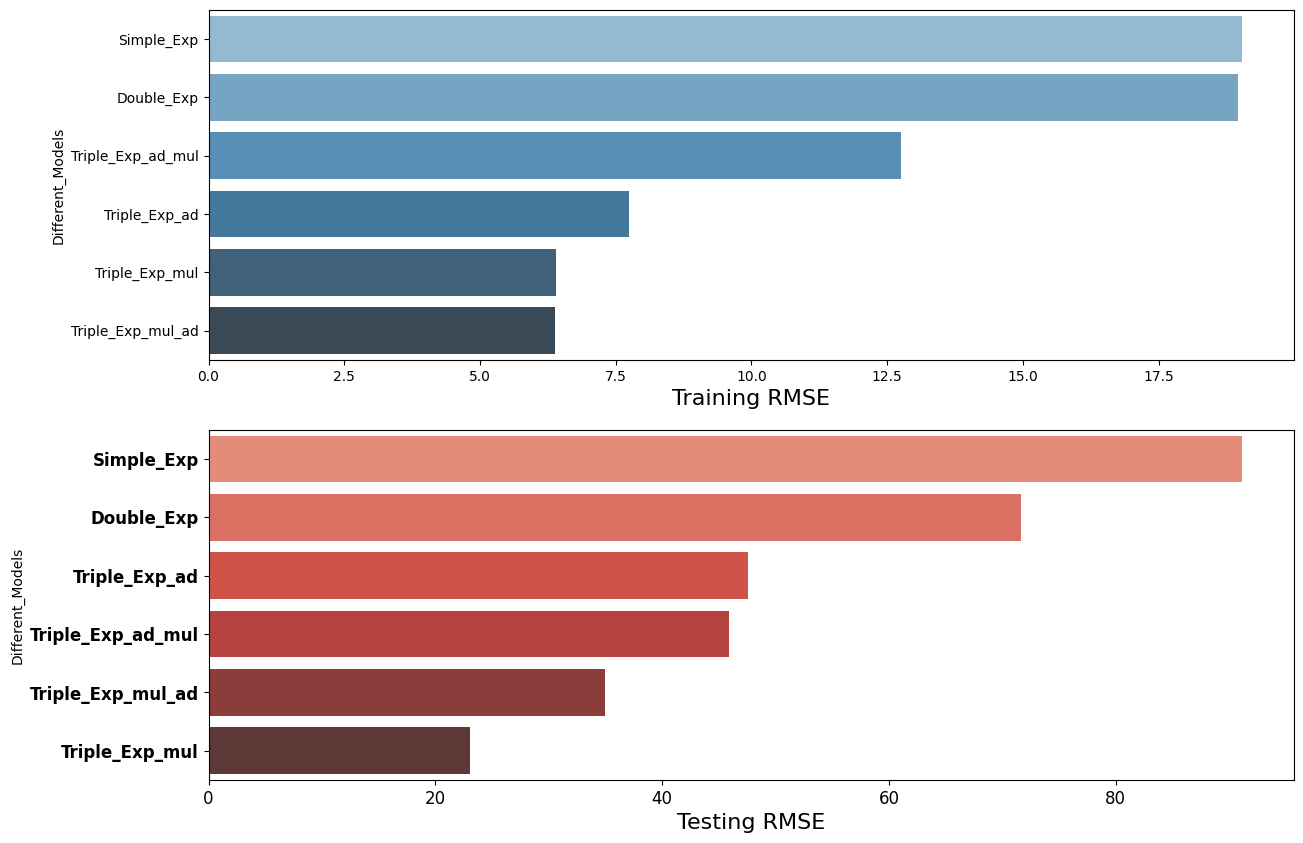

In [266]:
f, axes = plt.subplots(2,1, figsize=(14,10))
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=12)
train_rmse = table_evaluation.sort_values(by=['Train_RMSE'], ascending=False)

sn.barplot(x='Train_RMSE', y='Models', data = train_rmse, palette='Blues_d', ax = axes[0])
axes[0].set_xlabel('Training RMSE', size=16)
axes[0].set_ylabel('Different_Models')

test_rmse = table_evaluation.sort_values(by=['Test_RMSE_Values'], ascending=False)

sn.barplot(x='Test_RMSE_Values', y='Models', data = test_rmse, palette='Reds_d', ax = axes[1])
axes[1].set_xlabel('Testing RMSE', size=16)
axes[1].set_ylabel('Different_Models')

plt.show()

# Autoregressive Integrated Moving Averages (ARIMA)

### Stationary vs Non-stationary Time Series
### Test of Stationarity
As we have yearly data the window size for moving average is equal to 12


In [267]:
def test_stationary(timeseries):
    #determining rolling statistics
    movingAVG=timeseries.rolling(window=12).mean()
    movingSTD=timeseries.rolling(window=12).std()
    #Plotrolling statistics
    original=plt.plot(timeseries,color='Blue',label='Original')
    Mean=plt.plot(movingAVG,color='Red',label='Rolling mean')
    plt.legend(loc='best')
    plt.show()
    
    #Perform dicky-fuller test:
    print('Results of Dicky Fuller Test:')
    dftest=adfuller(timeseries['Passengers'],autolag='AIC')
    dfout=pd.Series(dftest[0:4],index=['Tst_Statisticss','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfout['Critical Value (%s)'%key] = value
    print(dfout)

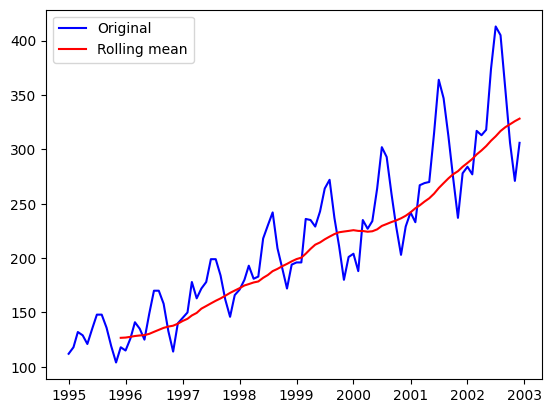

Results of Dicky Fuller Test:
Tst_Statisticss                 1.340248
p-value                         0.996825
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [268]:
passenger= pd.DataFrame()
passenger['Passengers'] = df1[['Passengers']]
test_stationary(passenger)


In [269]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):    
    result = adfuller(series.dropna())  
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    #for key,val in result[4].items():
        #out[f'critical value ({key})']=val
    if result[1] <= 0.05:
        print("Reject the null hypothesis/Accept Alternative Hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [270]:
adf_test(passenger)

Fail to reject the null hypothesis
Data is non-stationary


# Feature Scaling (Transformations)
### Square Root Transform

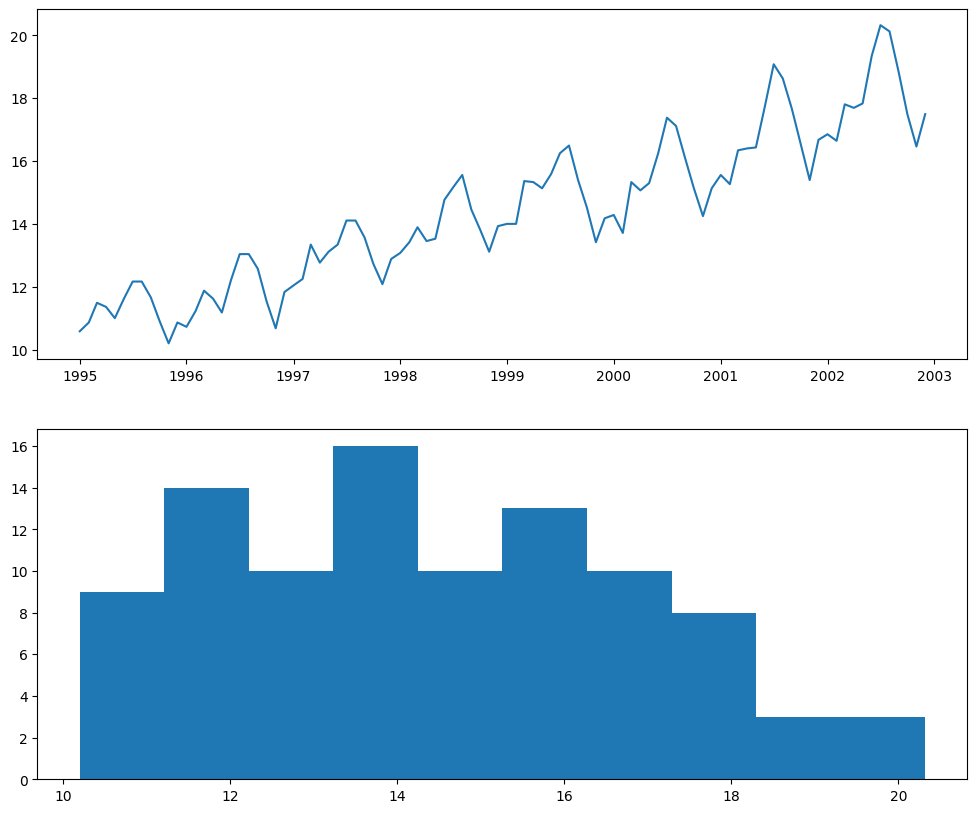

In [271]:
sqrt= pd.DataFrame()
sqrt = df1[['Passengers']]
sqrt['Passengers'] = np.sqrt(sqrt.Passengers)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(sqrt['Passengers'])
#Histogram
plt.subplot(212)
plt.hist(sqrt['Passengers'])
plt.show()

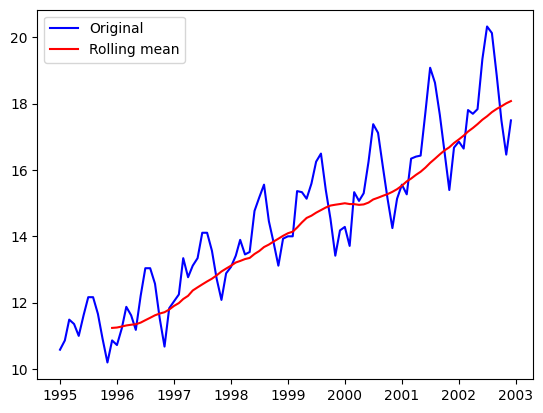

Results of Dicky Fuller Test:
Tst_Statisticss                 0.451435
p-value                         0.983320
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [272]:
test_stationary(sqrt)

In [273]:
adf_test(sqrt)

Fail to reject the null hypothesis
Data is non-stationary


### Log Transformation

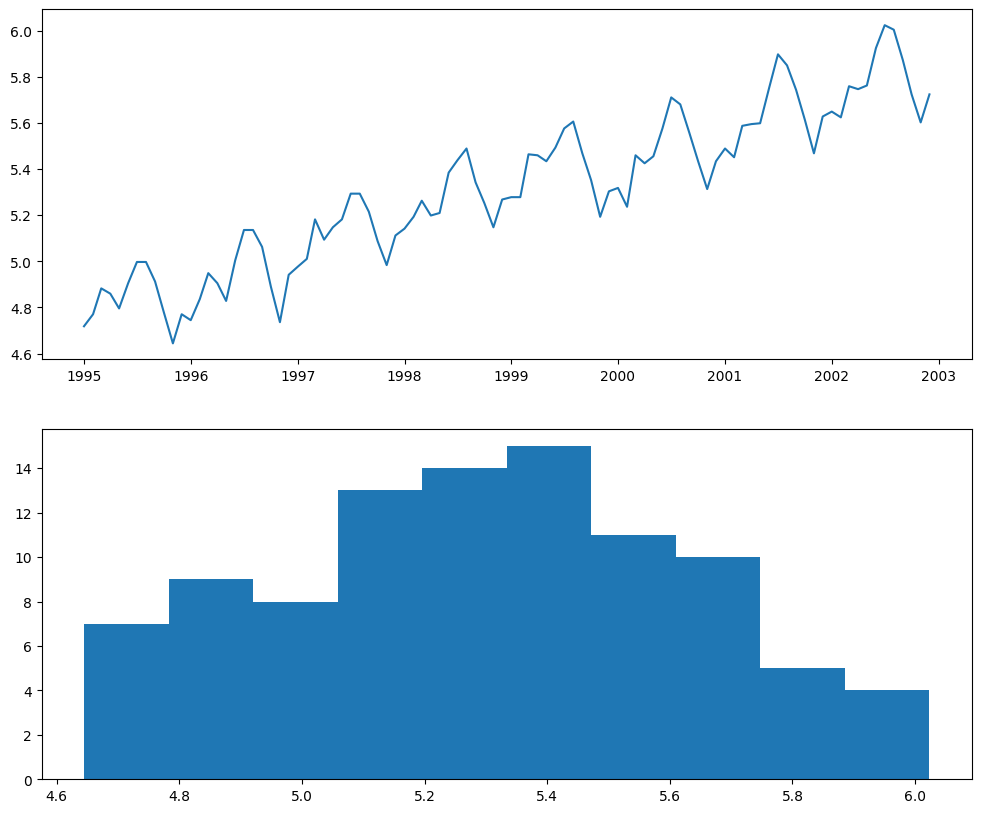

In [274]:
log = pd.DataFrame()
log = df1[['Passengers']]
log['Passengers'] = np.log(log.Passengers)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(log['Passengers'])
#Histogram
plt.subplot(212)
plt.hist(log['Passengers'])
plt.show()

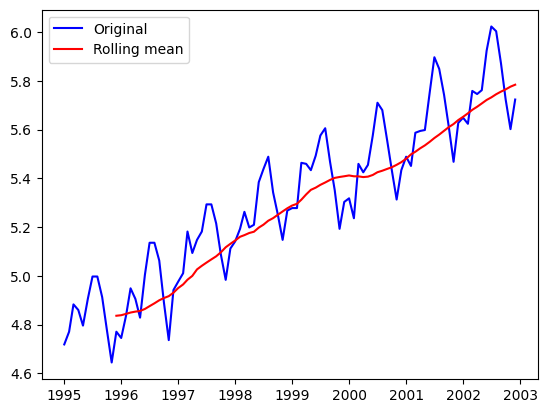

Results of Dicky Fuller Test:
Tst_Statisticss                -0.723027
p-value                         0.840695
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [275]:
test_stationary(log)

In [276]:
adf_test(log)

Fail to reject the null hypothesis
Data is non-stationary


**So we can say that Time-Series data is not Stationary.**

## Converting Non-Stationary Time Series into Stationary
### Differencing
In this method, we compute the difference of consecutive terms in the series. Differencing is typically performed to get rid of the varying mean. Mathematically, differencing can be written as:

#### yt‘ = yt – y(t-1)

where yt is the value at a time t

Applying differencing on our series and plotting the results:

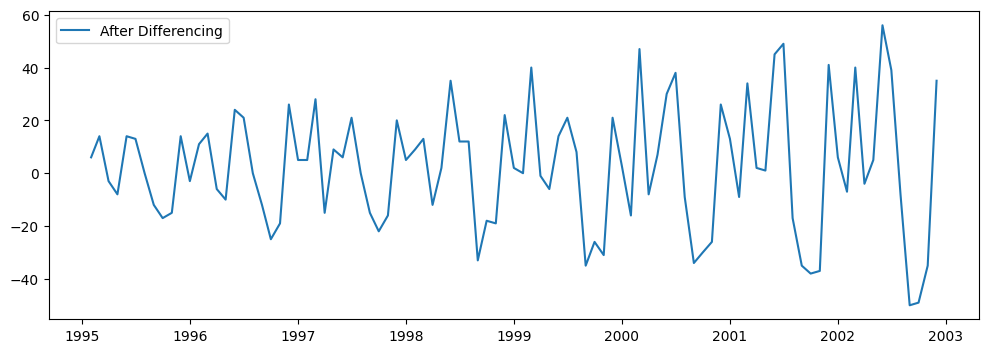

In [277]:
diff = df1['Passengers'] - df1['Passengers'].shift(1)
diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(diff, label='After Differencing')
plt.legend(loc='best')
plt.show()

In [278]:
adf_test(diff)

Fail to reject the null hypothesis
Data is non-stationary


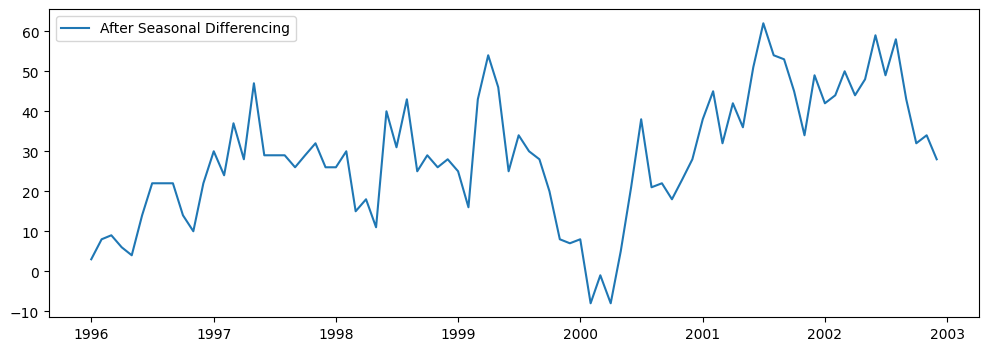

In [279]:
seasonal_differencing = df1['Passengers'] - df1['Passengers'].shift(12)
seasonal_differencing.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(seasonal_differencing, label='After Seasonal Differencing')
plt.legend(loc='best')
plt.show()

In [280]:
adf_test(seasonal_differencing)

Fail to reject the null hypothesis
Data is non-stationary


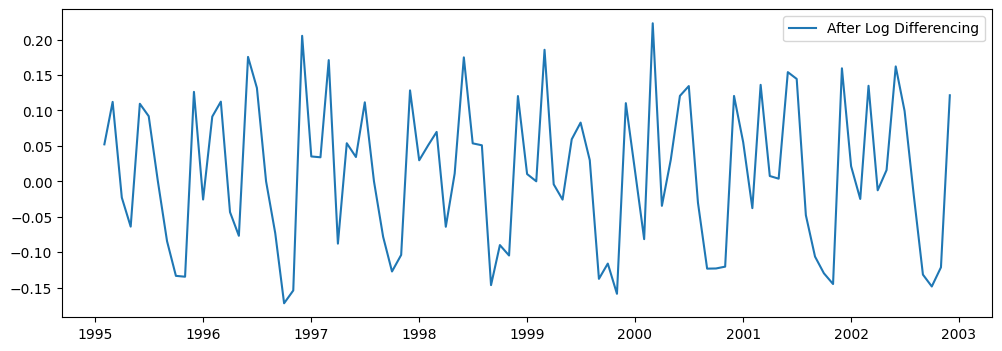

In [281]:
log_diff = log - log.shift(1)
log_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(log_diff, label='After Log Differencing')
plt.legend(loc='best')
plt.show()

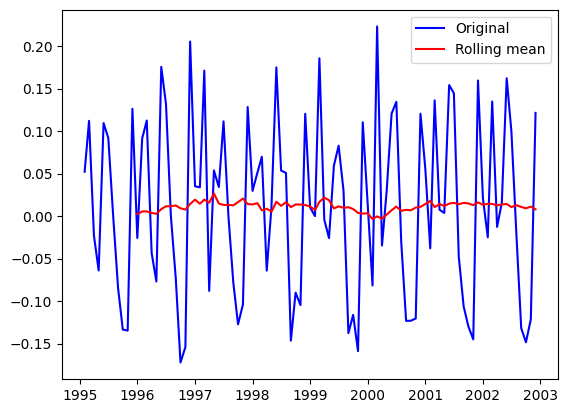

Results of Dicky Fuller Test:
Tst_Statisticss                -2.670823
p-value                         0.079225
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [282]:
test_stationary(log_diff)

In [283]:
adf_test(log_diff)

Fail to reject the null hypothesis
Data is non-stationary


In [284]:
### Box Cox Transformation


Passengers
Date                  
1995-01-01    4.718499
1995-02-01    4.770685
1995-03-01    4.882802
1995-04-01    4.859812
1995-05-01    4.795791

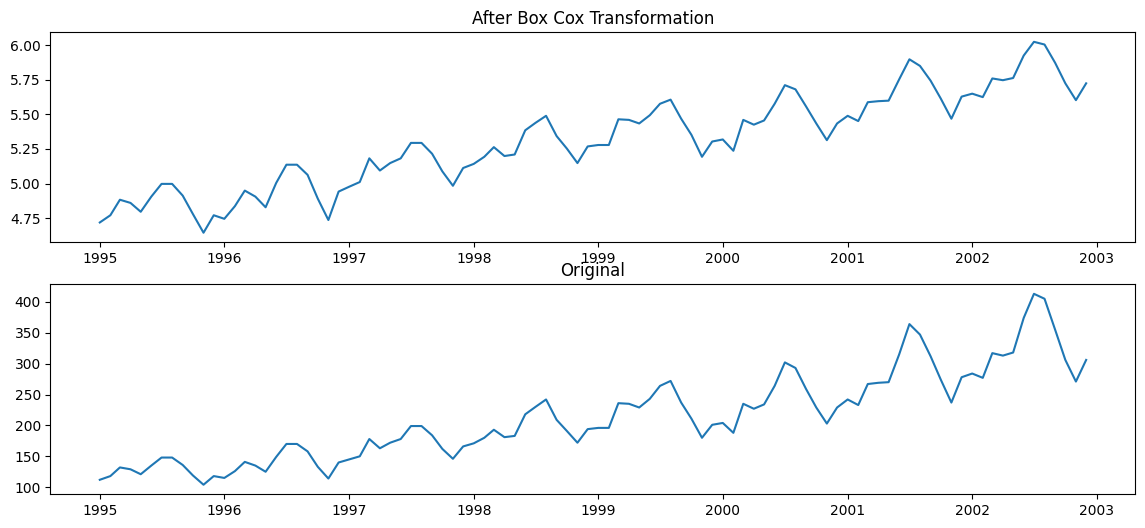

In [285]:
data_boxcox = pd.DataFrame()
data_boxcox['Passengers'] = pd.Series(boxcox(df1['Passengers'], lmbda=0), df1.index)
display(data_boxcox.head())
fig, axis = plt.subplots(2,figsize=(14,6))
axis[0].plot(data_boxcox)
axis[0].set_title('After Box Cox Transformation')
axis[1].plot(df1.Passengers, label='original')
axis[1].set_title('Original')
plt.show()

- We can see the variance became almost constant after the transformation. Both in the earlier and later years the variance is almost similar.
- But we can see that still the series has an upward trend. So, the mean is not constant yet. Hence, we need to do Differencing for making the mean constant.

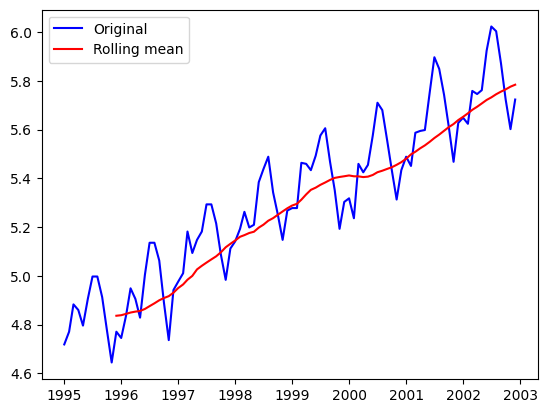

Results of Dicky Fuller Test:
Tst_Statisticss                -0.723027
p-value                         0.840695
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [286]:
test_stationary(data_boxcox)

In [287]:
adf_test(data_boxcox)

Fail to reject the null hypothesis
Data is non-stationary


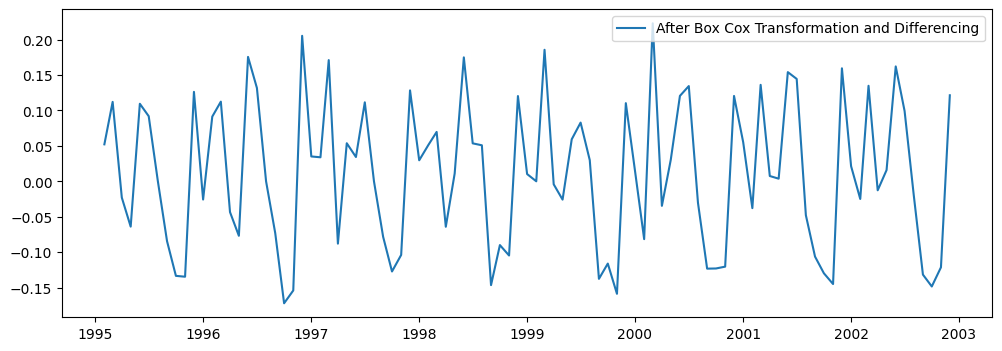

In [288]:
data_boxcox_diff = data_boxcox - data_boxcox.shift()
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox Transformation and Differencing')
plt.legend(loc='best')
plt.show()

- Now,We can see that there is no trend (upward or downward) after differencing on the Box Cox transformation.
- It is a horizontal trend.
- The mean became constant. The mean is zero.
- Also, the variance is almost constant.


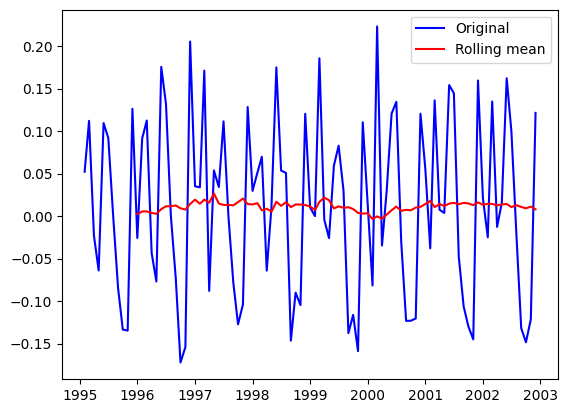

Results of Dicky Fuller Test:
Tst_Statisticss                -2.670823
p-value                         0.079225
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [289]:
test_stationary(data_boxcox_diff)

In [290]:
adf_test(data_boxcox_diff)

Fail to reject the null hypothesis
Data is non-stationary


In [291]:
data_boxcox_diff

Passengers
Date                  
1995-02-01    0.052186
1995-03-01    0.112117
1995-04-01   -0.022990
1995-05-01   -0.064022
1995-06-01    0.109484
...                ...
2002-08-01   -0.019561
2002-09-01   -0.131769
2002-10-01   -0.148533
2002-11-01   -0.121466
2002-12-01    0.121466

[95 rows x 1 columns]

**Finally, Our Series is now stationary for AR Forecasting.**
## ARIMA 

In [ ]:
from pmdarima import auto_arima

In [292]:
stepwise_fit = auto_arima(data_boxcox_diff, start_p = 1, start_q = 1,
                          max_p = 3, max_q = 3, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise
  
# To print the summary
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=-288.352, Time=1.32 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-256.406, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-282.679, Time=0.39 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-289.559, Time=0.50 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-258.383, Time=0.35 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=-265.389, Time=0.13 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=-287.636, Time=1.18 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=-287.633, Time=1.17 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=-284.433, Time=0.38 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=-285.681, Time=1.81 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=-281.171, Time=0.79 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=-287.911, Time=0.94 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=-288.313, Time=0.51 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=-285.570, Time=0.88 sec
 ARIMA(0,0,1)(0,1,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   95
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 12)   Log Likelihood                 148.760
Date:                            Mon, 21 Nov 2022   AIC                           -291.520
Time:                                    17:20:27   BIC                           -284.264
Sample:                                02-01-1995   HQIC                          -288.605
                                     - 12-01-2002                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3944      0.109     -3.615      0.000      -0.608      -0.181
ma.S.L12      -0.6126      0.130     -4.701      0.000      -0.868      -0.357
sigma2         0.0015      0.000      6.753      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 0.57
Prob(Q):                              0.82   Prob(JB):                         0.75
Heteroskedasticity (H):               0.35   Skew:                             0.01
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [293]:
data_boxcox

Passengers
Date                  
1995-01-01    4.718499
1995-02-01    4.770685
1995-03-01    4.882802
1995-04-01    4.859812
1995-05-01    4.795791
...                ...
2002-08-01    6.003887
2002-09-01    5.872118
2002-10-01    5.723585
2002-11-01    5.602119
2002-12-01    5.723585

[96 rows x 1 columns]

In [294]:
train_data_boxcox = data_boxcox[:size]
test_data_boxcox = data_boxcox[size:]
train_data_boxcox_diff = data_boxcox_diff[:size]
test_data_boxcox_diff = data_boxcox_diff[size:]

In [295]:
model = ARIMA(train_data_boxcox_diff, order=(0, 1, 1))
model_fit = model.fit()
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['arima_forecast'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
# We did differencing. So we need to revert it by adding the consecutive observations.
# For that we are using cumsum() method
y_hat_ar['arima_forecast'] = y_hat_ar['arima_forecast'].cumsum()
# We removed the first observations after differencing as it was null. Hence, adding the first observation back.
y_hat_ar['arima_forecast'] = y_hat_ar['arima_forecast'].add(data_boxcox.Passengers[0])
# Now doing the reverse transformation 
# We have done Box Cox Log Log transformation with lambda = 0
# Hence, we have to the exponential as it is the reverse of the log.
y_hat_ar['arima_forecast'] = np.exp(y_hat_ar['arima_forecast'])


In [296]:
y_hat_ar['arima_forecast']

Date
1995-02-01    112.000000
1995-03-01    118.000000
1995-04-01    128.103195
1995-05-01    134.281811
1995-06-01    136.901759
                 ...    
2002-08-01    420.990020
2002-09-01    425.519023
2002-10-01    430.096748
2002-11-01    434.723720
2002-12-01    439.400469
Name: arima_forecast, Length: 95, dtype: float64

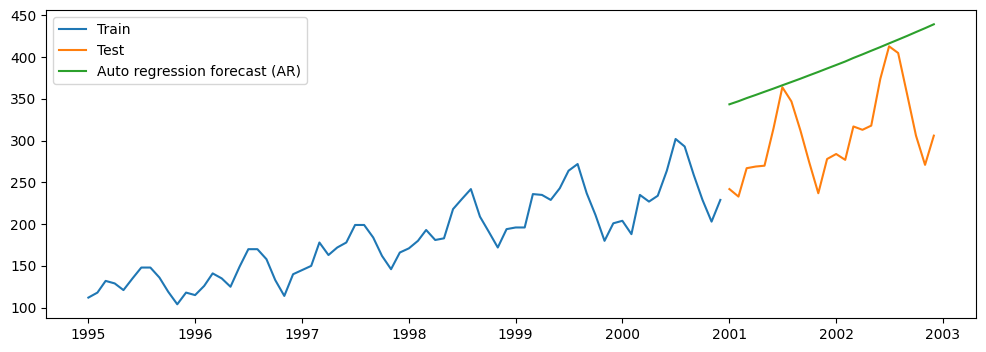

In [297]:
plt.figure(figsize=(12,4))
plt.plot(train_df['Passengers'], label='Train')
plt.plot(test_df['Passengers'], label='Test')
plt.plot(y_hat_ar['arima_forecast'][test_df.index.min():], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()


- We can see that we have done moderatey well.
- No seasonality captured.
- Only Trend was captured.

# Model Evaluation :
## RMSE

In [298]:
rmse_ARIMA = np.sqrt(mean_squared_error(test_df['Passengers'], y_hat_ar['arima_forecast'][test_df.index.min():])).round(2)
rmse_ARIMA
#['arima_forecast'][test_data.index.min():])).round(2)


93.74

## MAPE(Mean Absolute Percent Error)

In [299]:
mape_ARIMA=MAPE(y_hat_ar['arima_forecast'],test_df.Passengers)
mape_ARIMA

29.59483870768548

- So, Here we can see that AR model has done reaonably good job but not better than Holt's Method.
- But, We are not compare it with Holt's winter method because it captures seasonality.  

### Analysing residual :
- **The mean of Residual should be 0 or close to zero**

In [300]:
model_residual=model_fit.resid
model_residual.mean()

-0.004866131013501222

In [301]:
adf_test(model_residual)

Reject the null hypothesis/Accept Alternative Hypothesis
Data is stationary


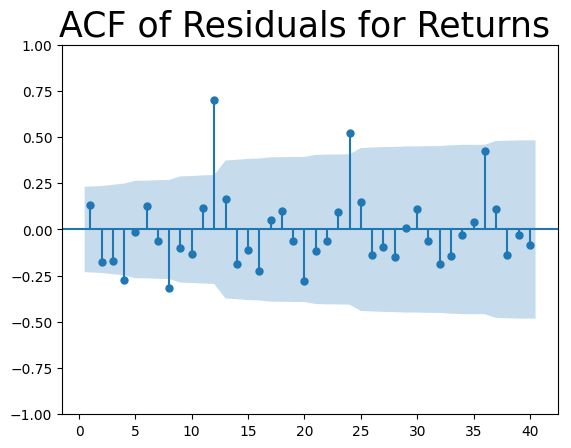

In [302]:
plot_acf(model_residual,zero=False,lags=40)
plt.title("ACF of Residuals for Returns ",size=25)
plt.show()

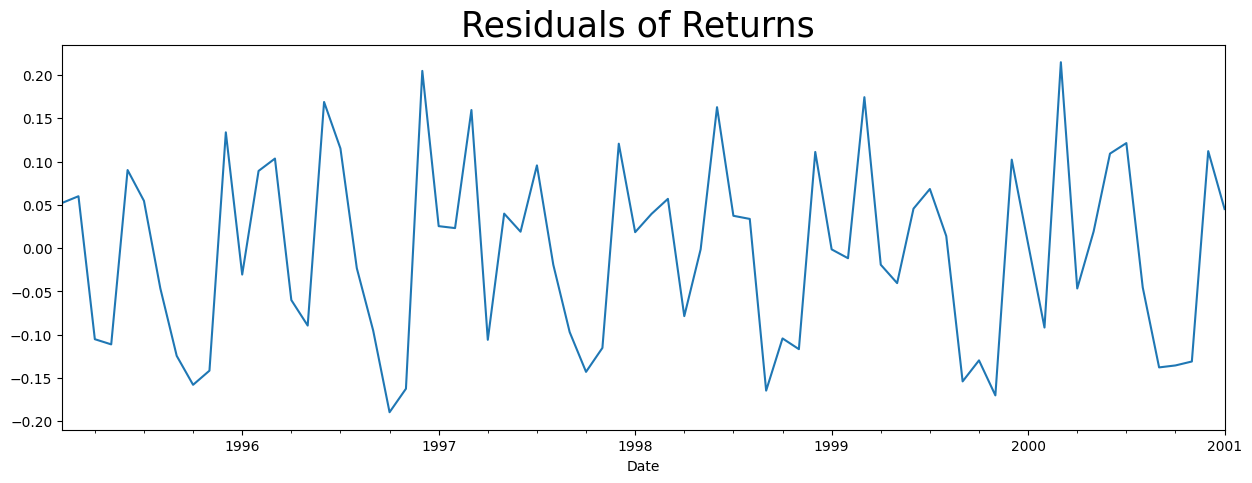

In [303]:
model_residual.plot(figsize=(15,5))
plt.title('Residuals of Returns ',size=25)
plt.show()

# Seasonal Auto Regressive Integrated Moving Averge(SARIMA)
- SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.
- It adds three new hyperparameters to specify the **autoregression (AR), differencing (I) and moving average (MA)** for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.
- A seasonal ARIMA model is formed by including additional seasonal terms in the ARIMA. The seasonal part of the model consists of terms that are very similar to the non-seasonal components of the model, but they involve backshifts of the seasonal period.

In [304]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# seasonal order P=1,Q=1,D=1 amd m=12

In [305]:
model_s=SARIMAX(train_data_boxcox,order=(1,1,1),seasonal_order=(1,1,1,12))
model_fit= model_s.fit()
y_hat_sarima = data_boxcox_diff.copy()

In [306]:
#Inverse Transformation of the Differencing Box-Cox Transformation

y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
#y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])


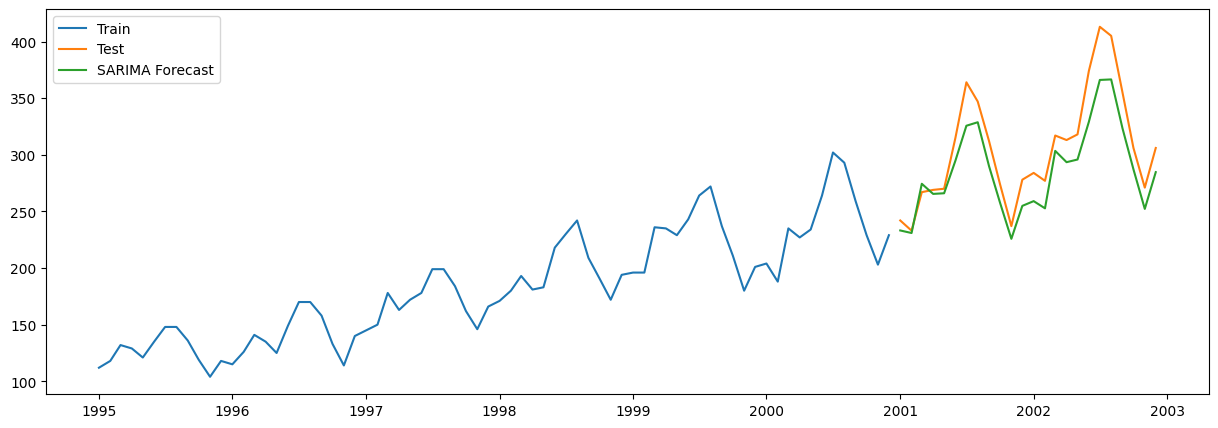

In [307]:
plt.figure(figsize=(15,5))
plt.plot(train_df['Passengers'],label='Train')
plt.plot(test_df['Passengers'],label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test_df.index.min():],label='SARIMA Forecast')
plt.legend(loc='best')
plt.show()

Now in the above plot we can  see that we are able to capturethe trend and seasonality. 

## Model Evalutaion
### RMSE

In [308]:
rmse_SARIMA = np.sqrt(mean_squared_error(test_df['Passengers'], y_hat_sarima['sarima_forecast'][test_df.index.min():])).round(2)
rmse_SARIMA

24.1

### MAPE

In [309]:
mape_SARIMA= MAPE(y_hat_sarima['sarima_forecast'],test_df.Passengers)
mape_SARIMA

6.471836510902327

- SARIMA method has done reasonably well as it captures seasonality.
- The performance is comparable with the other methods such as Holt's Winter additive/multiplicative, whcich also captures seasonality.

## Analysing Residuals

In [310]:
model_residual=model_fit.resid
model_residual.mean()

0.03585484451906838

In [311]:
adf_test(model_residual)

Reject the null hypothesis/Accept Alternative Hypothesis
Data is stationary


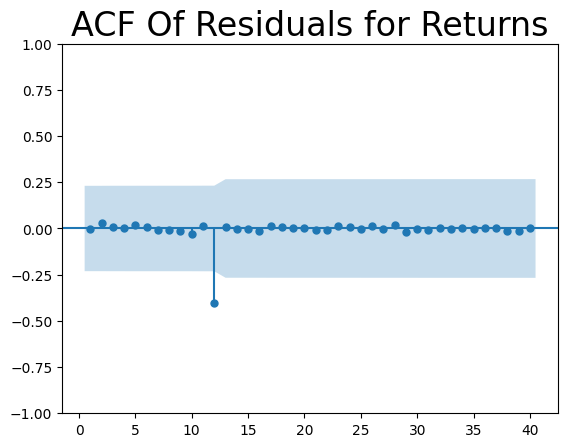

In [312]:
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

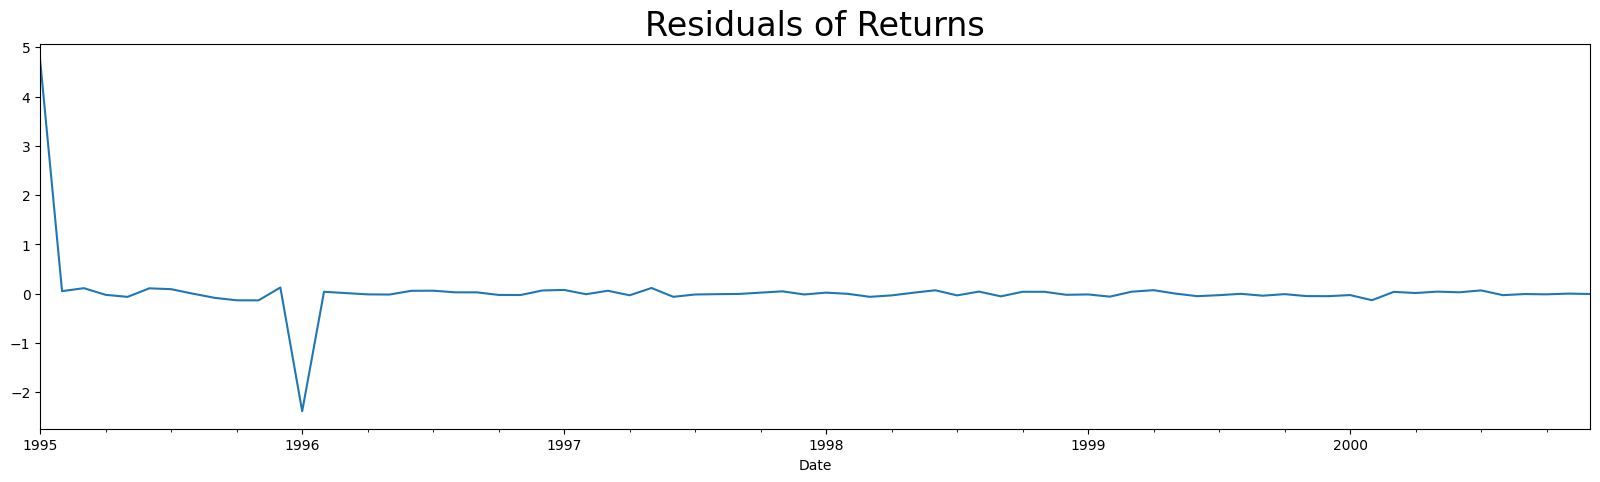

In [313]:
model_residual.plot(figsize=(20,5))
plt.title("Residuals of Returns", size=24)
plt.show()

In [314]:
table_evaluation

Models  Train_RMSE  Test_MAPE(%)  Test_RMSE_Values
0     Triple_Exp_mul    6.396750      6.035068         23.058821
1  Triple_Exp_mul_ad    6.386634      9.368507         34.989901
2      Triple_Exp_ad    7.751304     12.084271         47.568531
3  Triple_Exp_ad_mul   12.745962     12.720039         45.891606
4         Double_Exp   18.961290     17.149026         71.634778
5         Simple_Exp   19.031772     23.382283         91.113254

## Creating table of all models

In [315]:
#Comparing the results 
Evaluation = {"Models":pd.Series(["Simple_Exponential","Double_Exponential","Triple_Exp_additive","Triple_Exp_mul_ad","Triple_Exp_ad_mul"\
                                  ,"Triple_Exp_multiplicative","ARIMA","SARIMA"]),\
        "MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp,mape_ARIMA,mape_SARIMA]),\
        
        "RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp,rmse_ARIMA,rmse_SARIMA])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)
table_evaluation

Models    MAPE(%)  RMSE_Values
0  Triple_Exp_multiplicative   6.035068    23.058821
1                     SARIMA   6.471837    24.100000
2          Triple_Exp_mul_ad   9.368507    34.989901
3          Triple_Exp_ad_mul  12.720039    45.891606
4        Triple_Exp_additive  12.084271    47.568531
5         Double_Exponential  17.149026    71.634778
6         Simple_Exponential  23.382283    91.113254
7                      ARIMA  29.594839    93.740000

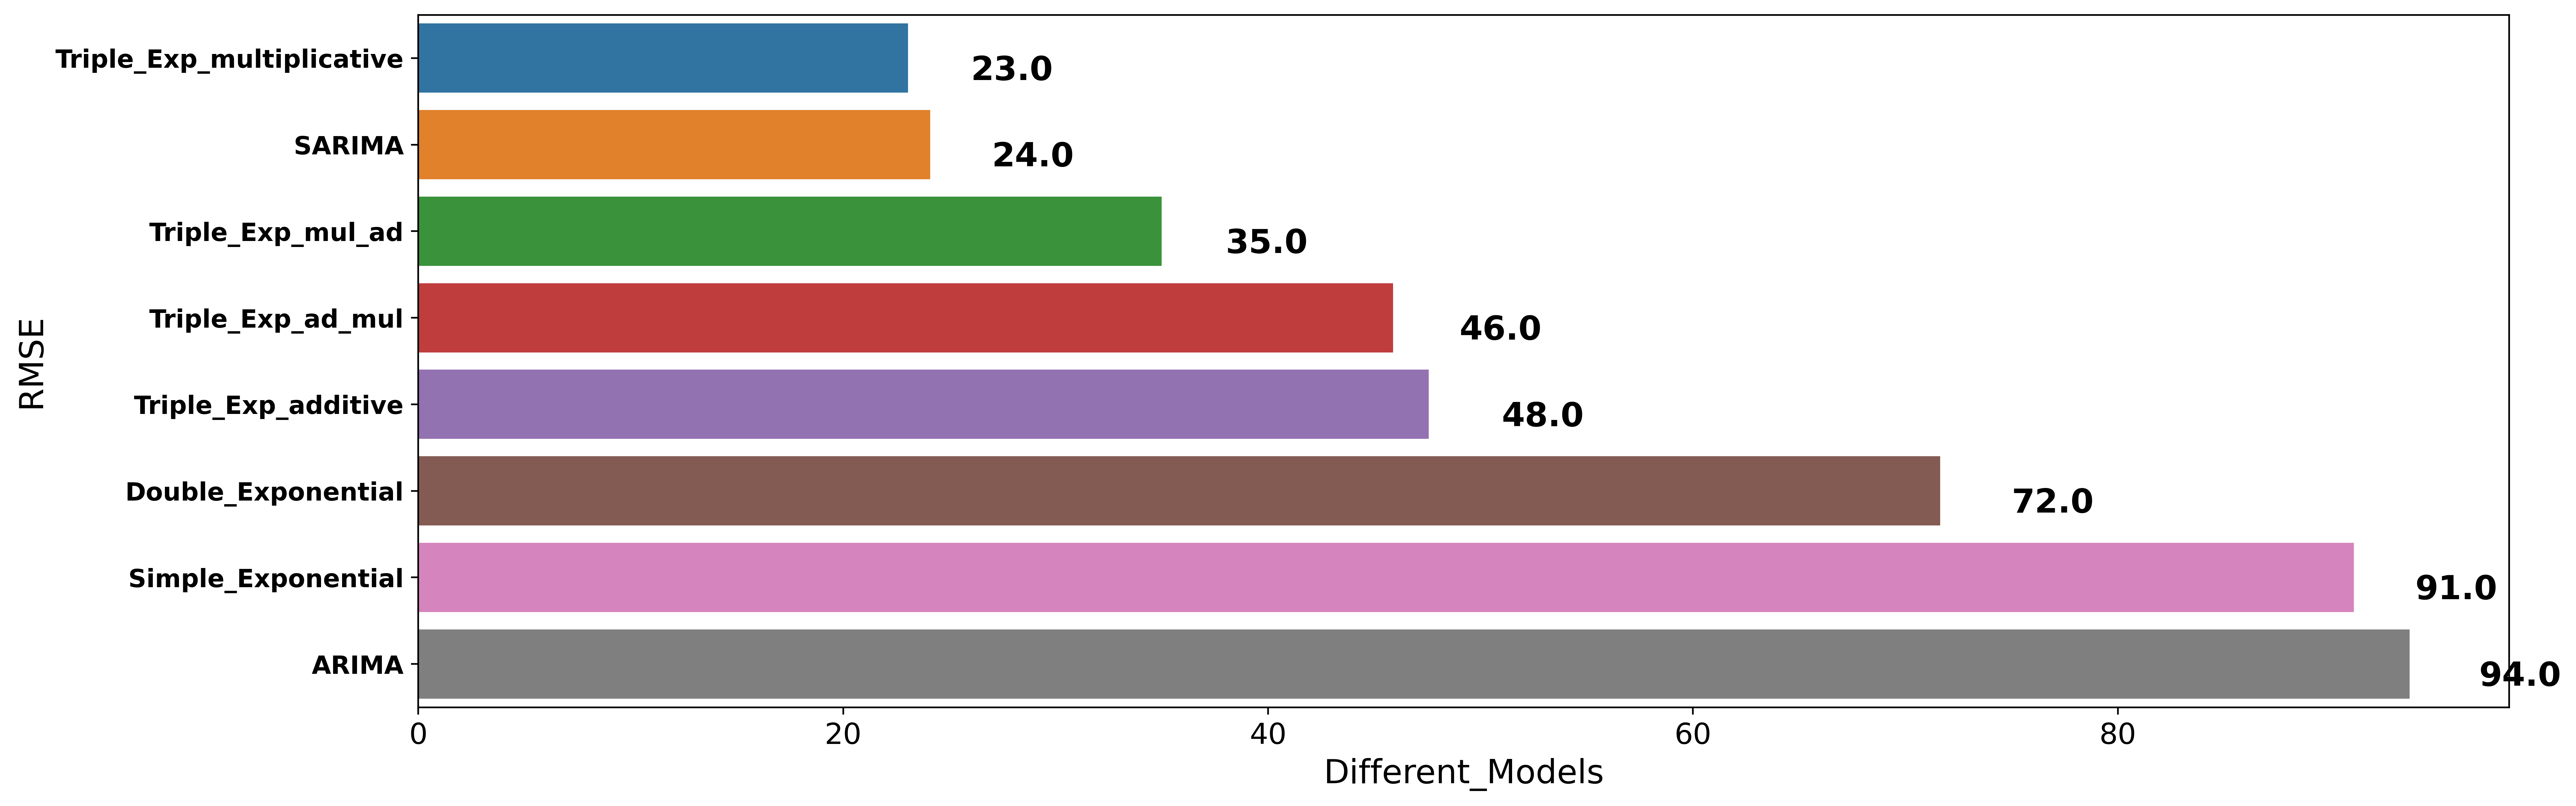

In [316]:
f, axe = plt.subplots(1,1, figsize=(18,6), dpi=500)
sn.barplot(x='RMSE_Values', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=14)


for i, v in enumerate(np.round(table_evaluation.RMSE_Values.values,0)):
    axe.text(v + 3, i + .25, str(v),
            color = 'black', fontweight = 'bold', fontsize= 16)

plt.show()

- The Sarima Model did very well as compared to other Models but Holts-Winter Method did slightly better.
- Even in methods such as Triple Exponential Smoothing (Holts-Winters Method) taking Seasonality and Trend as Multiplicative gave the best restult in this case

# The best model we got so far with lowest RMSE is SARIMA and Triple Exponential multiplicative model.